In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
import anndata
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad
import importlib
import PlotConfusion as pc
importlib.reload(pc)
import PlotConfusion as pc
import matplotlib
import scipy.stats as stats
import random
import math
import pickle
import matplotlib.patheffects as pe
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import scipy.cluster.hierarchy as sch

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [3]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
plt.rcParams.update({'axes.labelsize' : 16}) 

In [4]:
biological_types = ["1_W3L1",
                    "2_W3D1",
                    "3_F-mini-ON",
                    "4_F-mini-OFF",
                    "5_J-RGC",
                    "6_W3B",
                    "7_Novel",
                    "8_Novel",
                    "9_Tbr1-Novel",
                    "10_ooDSGC",
                    "11_Novel",
                    "12_N-ooDSGC",
                    "13_W3L2",
                    "14_Novel",
                    "15_Novel",
                    "16_D/V-ooDSGC",
                    "17_Tbr1-S1",
                    "18_Novel",
                    "19_Novel",
                    "20_Novel",
                    "21_Tbr1-S2",
                    "22_MX",
                    "23_W3D2",
                    "24_ooDSGC",
                    "25_Novel",
                    "26_Novel",
                    "27_Novel",
                    "28_F-midi-OFF",
                    "29_Novel",
                    "30_W3D3",
                    "31_M2",
                    "32_F-Novel",
                    "33_M1",
                    "34_Novel",
                    "35_Novel",
                    "36_Novel",
                    "37_Novel",
                    "38_F-midi-ON",
                    "39_Novel",
                    "40_M1-duplicate",
                    "41_alphaON-T",
                    "42_alphaOFF-S",
                    "43_alphaON-S/M4",
                    "44_Novel",
                    "45_alphaOFF-T"
]

In [5]:
DS_types = ['D-ON/OFF', 'V-ON/OFF', 'N-ON/OFF', 'T-ON/OFF', 'N-ON', 'D-ON', 'V-ON']

In [6]:
def make_type_scatter(fold_changes_1, fold_changes_2, blacklists, xlabel, ylabel, figname, DE_genes_up, DE_genes_down, xlims=(-6,6), ylims=(-6,6), LFC_thresh=2, test_genes=[], title=''):
    #start from top left and move right then down, like reading
    square_counts = [0,0,0,0,0,0,0,0,0]
    up_counts = [0,0,0]
    down_counts = [0,0,0]
    for x in tqdm(range(len(fold_changes_1))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = [fold_changes_1[x][i] for i in range(len(fold_changes_1[x])) if i not in blacklist]
        y_FC = [fold_changes_2[x][i] for i in range(len(fold_changes_2[x])) if i not in blacklist]
        
        for i in range(len(x_FC)):
            square_index_1 = 0
            square_index_2 = 0
            if np.log2(y_FC[i]) >= LFC_thresh:
                square_index_1 = 0
            elif np.log2(y_FC[i]) >= -LFC_thresh:
                square_index_1 = 3
            else:
                square_index_1 = 6
            
            if np.log2(x_FC[i]) <= -LFC_thresh:
                square_index_2 = 0
            elif np.log2(x_FC[i]) <= LFC_thresh:
                square_index_2 = 1
            else:
                square_index_2 = 2
            
            square_index = square_index_1+square_index_2
            square_counts[square_index] += 1
        
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c='black')
    for x in tqdm(range(len(test_genes))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        for i in test_genes[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                x_FC.append(fold_changes_1[x][gene_index])
                y_FC.append(fold_changes_2[x][gene_index])
        
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c='gray')
    for x in tqdm(range(len(DE_genes_up))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        top_count = 0
        middle_count = 0
        bottom_count = 0
        for i in DE_genes_up[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                x_FC.append(fold_changes_1[x][gene_index])
                y_FC.append(fold_changes_2[x][gene_index])
                if np.log2(fold_changes_2[x][gene_index]) >= LFC_thresh:
                    top_count += 1
                elif np.log2(fold_changes_2[x][gene_index]) <= -LFC_thresh:
                    bottom_count += 1
                else:
                    middle_count += 1

        up_counts[0] += top_count
        up_counts[1] += middle_count
        up_counts[2] += bottom_count
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c='#2171b5')
    for x in tqdm(range(len(DE_genes_down))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        top_count = 0
        middle_count = 0
        bottom_count = 0
        for i in DE_genes_down[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                x_FC.append(fold_changes_1[x][gene_index])
                y_FC.append(fold_changes_2[x][gene_index])
                if np.log2(fold_changes_2[x][gene_index]) >= LFC_thresh:
                    top_count += 1
                elif np.log2(fold_changes_2[x][gene_index]) <= -LFC_thresh:
                    bottom_count += 1
                else:
                    middle_count += 1
        
        down_counts[0] += top_count
        down_counts[1] += middle_count
        down_counts[2] += bottom_count
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c='#cb181d')
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0],ylims[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(xlims[0], xlims[1]+1, 2))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.grid(False)
    plt.plot([-LFC_thresh,-LFC_thresh],[ylims[0],ylims[1]], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([LFC_thresh,LFC_thresh],[ylims[0],ylims[1]], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([xlims[0],xlims[1]],[-LFC_thresh,-LFC_thresh], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([xlims[0],xlims[1]],[LFC_thresh,LFC_thresh], c='red', linestyle='dashed', linewidth=0.8)
    xs = [xlims[0]+1,0,xlims[1]-1,xlims[0]+1,0,xlims[1]-1,xlims[0]+1,0,xlims[1]-1]
    ys = [ylims[1]-1,ylims[1]-1,ylims[1]-1,0,0,0,ylims[0]+1,ylims[0]+1,ylims[0]+1]
    for i in range(len(square_counts)):
        if i != 4:
            x = xs[i]
            y = ys[i]
            label = square_counts[i]
            plt.text(x, y, label, va='center', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
    xs_DE = [xlims[0]+1,xlims[0]+1,xlims[0]+1,xlims[1]-1,xlims[1]-1,xlims[1]-1]
    ys_DE = [ylims[1]-1.7,-0.7,ylims[0]+0.3,ylims[1]-1.7,-0.7,ylims[0]+0.3]
    for i in range(len(up_counts)+len(down_counts)):
        x = xs_DE[i]
        y = ys_DE[i]
        if i < 3:
            label = down_counts[i]
            plt.text(x, y, label, fontsize=10, color='#cb181d', va='center', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
        else:
            label = up_counts[i-3]
            plt.text(x, y, label, fontsize=10, color='#2171b5',  va='center', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
    plt.title(title)
    plt.savefig(figname, bbox_inches='tight')

In [7]:
p5_adata = sc.read_h5ad('adatas/P5_adata_typed.h5ad')
p7_adata = sc.read_h5ad('adatas/P7_adata_pruned.h5ad')
p56_adata = sc.read_h5ad('adatas/P56_adata.h5ad')

In [8]:
p7b2_adata = sc.read_h5ad('adatas/P7b2_adata_pruned.h5ad')

In [9]:
p5_adata_DS = sc.read_h5ad('adatas/P5_adata_DS.h5ad')
p7_adata_combined_DS = sc.read_h5ad('adatas/P7_adata_DS.h5ad')
p7_adata_DS = p7_adata_combined_DS[p7_adata_combined_DS.obs['Condition'] == 'Control']
p7b2_adata_DS = p7_adata_combined_DS[p7_adata_combined_DS.obs['Condition'] == 'β2-KO']
p56_adata_DS = sc.read_h5ad('adatas/P56_adata_DS.h5ad')

In [10]:
p5_adata_raw = p5_adata.raw
p7_adata_raw = p7_adata.raw
p56_adata_raw = p56_adata.raw

In [11]:
p7b2_adata_raw = p7b2_adata.raw

In [12]:
common_genes = []
for i in list(p5_adata_raw.var_names):
    if (i in p7_adata_raw.var_names) & (i in p56_adata_raw.var_names):
        common_genes.append(i)

In [13]:
p5_adata_slice = p5_adata_raw[:, common_genes]
p7_adata_slice = p7_adata_raw[:, common_genes]
p56_adata_slice = p56_adata_raw[:, common_genes]

In [14]:
p7b2_adata_slice = p7b2_adata_raw[:, common_genes]

In [15]:
gene_names = list(p5_adata_slice.var_names)

In [16]:
p7_p5_fold_changes = pickle.load(open('p7_p5_fold_changes.pkl', 'rb'))
p7_p56_fold_changes = pickle.load(open('p7_p56_fold_changes.pkl', 'rb'))
p56_p5_fold_changes = pickle.load(open('p56_p5_fold_changes.pkl', 'rb'))
p56_p7_fold_changes = pickle.load(open('p56_p7_fold_changes.pkl', 'rb'))
p7b2_p7_fold_changes = pickle.load(open('p7b2_p7_fold_changes.pkl', 'rb'))
p7b2_p56_fold_changes = pickle.load(open('p7b2_p56_fold_changes.pkl', 'rb'))
p7b2_p5_fold_changes = pickle.load(open('p7b2_p5_fold_changes.pkl', 'rb'))
p7_p7b2_fold_changes = pickle.load(open('p7_p7b2_fold_changes.pkl', 'rb'))

In [17]:
p7_p5_blacklist = pickle.load(open('p7_p5_blacklist.pkl', 'rb'))
p7_p56_blacklist = pickle.load(open('p7_p56_blacklist.pkl', 'rb'))
p7_p7b2_blacklist = pickle.load(open('p7_p7b2_blacklist.pkl', 'rb'))
p5_p56_blacklist = pickle.load(open('p5_p56_blacklist.pkl', 'rb'))
p5_p7b2_blacklist = pickle.load(open('p5_p7b2_blacklist.pkl', 'rb'))
p56_p7b2_blacklist = pickle.load(open('p56_p7b2_blacklist.pkl', 'rb'))

In [18]:
p7rep1_p7rep2_fold_changes = pickle.load(open('p7rep1_p7rep2_fold_changes.pkl', 'rb'))
p7rep1_p7rep3_fold_changes = pickle.load(open('p7rep1_p7rep3_fold_changes.pkl', 'rb'))
p7rep2_p7rep3_fold_changes = pickle.load(open('p7rep2_p7rep3_fold_changes.pkl', 'rb'))
p7b2rep1_p7b2rep2_fold_changes = pickle.load(open('p7b2rep1_p7b2rep2_fold_changes.pkl', 'rb'))
p7b2rep1_p7b2rep3_fold_changes = pickle.load(open('p7b2rep1_p7b2rep3_fold_changes.pkl', 'rb'))
p7b2rep2_p7b2rep3_fold_changes = pickle.load(open('p7b2rep2_p7b2rep3_fold_changes.pkl', 'rb'))

In [19]:
p7_p5_fold_changes_by_type = pickle.load(open('p7_p5_fold_changes_by_type.pkl', 'rb'))
p7_p56_fold_changes_by_type = pickle.load(open('p7_p56_fold_changes_by_type.pkl', 'rb'))
p56_p5_fold_changes_by_type = pickle.load(open('p56_p5_fold_changes_by_type.pkl', 'rb'))
p56_p7_fold_changes_by_type = pickle.load(open('p56_p7_fold_changes_by_type.pkl', 'rb'))
p7b2_p7_fold_changes_by_type = pickle.load(open('p7b2_p7_fold_changes_by_type.pkl', 'rb'))
p7b2_p56_fold_changes_by_type = pickle.load(open('p7b2_p56_fold_changes_by_type.pkl', 'rb'))
p7b2_p5_fold_changes_by_type = pickle.load(open('p7b2_p5_fold_changes_by_type.pkl', 'rb'))
p7_p7b2_fold_changes_by_type = pickle.load(open('p7_p7b2_fold_changes_by_type.pkl', 'rb'))

In [20]:
p7_p5_blacklist_by_type = pickle.load(open('p7_p5_blacklist_by_type.pkl', 'rb'))
p7_p56_blacklist_by_type = pickle.load(open('p7_p56_blacklist_by_type.pkl', 'rb'))
p7_p7b2_blacklist_by_type = pickle.load(open('p7_p7b2_blacklist_by_type.pkl', 'rb'))
p5_p56_blacklist_by_type = pickle.load(open('p5_p56_blacklist_by_type.pkl', 'rb'))
p5_p7b2_blacklist_by_type = pickle.load(open('p5_p7b2_blacklist_by_type.pkl', 'rb'))
p56_p7b2_blacklist_by_type = pickle.load(open('p56_p7b2_blacklist_by_type.pkl', 'rb'))

In [21]:
p7_p5_fold_changes_by_type_DS = pickle.load(open('p7_p5_fold_changes_by_type_DS.pkl', 'rb'))
p7b2_p7_fold_changes_by_type_DS = pickle.load(open('p7b2_p7_fold_changes_by_type_DS.pkl', 'rb'))
p7b2_p5_fold_changes_by_type_DS = pickle.load(open('p7b2_p5_fold_changes_by_type_DS.pkl', 'rb'))
p7_p7b2_fold_changes_by_type_DS = pickle.load(open('p7_p7b2_fold_changes_by_type_DS.pkl', 'rb'))

In [22]:
LFC_cutoff_genes = []
LFC_cutoff_gene_FCs = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p7b2_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes.append(cutoff_genes)
    LFC_cutoff_gene_FCs.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 61.77it/s]


In [23]:
LFC_cutoff_genes_up = []
LFC_cutoff_gene_FCs_up = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p7b2_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_up.append(cutoff_genes)
    LFC_cutoff_gene_FCs_up.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 44.33it/s]


In [24]:
LFC_cutoff_genes_down = []
LFC_cutoff_gene_FCs_down = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p7b2_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) < -1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_down.append(cutoff_genes)
    LFC_cutoff_gene_FCs_down.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 59.76it/s]


In [25]:
adata_combined_p7_type_list = []
for i in tqdm(range(len(biological_types))):
    P56_type = int(biological_types[i].split('_')[0])
    p7_adata_type = p7_adata[p7_adata.obs['P56_type'] == P56_type]
    p7b2_adata_type = p7b2_adata[p7b2_adata.obs['P56_type'] == P56_type]
    
    combined_p7_adata_type = ad.concat([p7_adata_type, p7b2_adata_type], label='Condition', keys=['WT', 'β2-KO'])
    
    sc.tl.rank_genes_groups(combined_p7_adata_type, groupby='Condition', method='wilcoxon', mask_var=combined_p7_adata_type.raw.var_names.isin(LFC_cutoff_genes[i]))
    
    adata_combined_p7_type_list.append(combined_p7_adata_type)

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


  2%|█▊                                                                                 | 1/45 [00:11<08:05, 11.03s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


  4%|███▋                                                                               | 2/45 [00:22<08:00, 11.18s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


  7%|█████▌                                                                             | 3/45 [00:33<07:58, 11.38s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


  9%|███████▍                                                                           | 4/45 [00:41<06:48,  9.96s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


 11%|█████████▏                                                                         | 5/45 [00:51<06:36,  9.90s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


 13%|███████████                                                                        | 6/45 [00:57<05:32,  8.53s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


 16%|████████████▉                                                                      | 7/45 [01:03<04:58,  7.86s/it]

ranking genes


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


 18%|██████████████▊                                                                    | 8/45 [01:10<04:30,  7.32s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 20%|████████████████▌                                                                  | 9/45 [01:11<03:21,  5.59s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 22%|██████████████████▏                                                               | 10/45 [01:15<02:58,  5.11s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


 24%|████████████████████                                                              | 11/45 [01:23<03:17,  5.81s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


 27%|█████████████████████▊                                                            | 12/45 [01:28<03:03,  5.55s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


 29%|███████████████████████▋                                                          | 13/45 [01:33<02:50,  5.33s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


 31%|█████████████████████████▌                                                        | 14/45 [01:37<02:39,  5.15s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 33%|███████████████████████████▎                                                      | 15/45 [01:40<02:11,  4.38s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


 36%|█████████████████████████████▏                                                    | 16/45 [01:44<02:04,  4.30s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 38%|██████████████████████████████▉                                                   | 17/45 [01:46<01:37,  3.49s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 40%|████████████████████████████████▊                                                 | 18/45 [01:49<01:32,  3.44s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 42%|██████████████████████████████████▌                                               | 19/45 [01:50<01:11,  2.75s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 44%|████████████████████████████████████▍                                             | 20/45 [01:52<01:04,  2.57s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 47%|██████████████████████████████████████▎                                           | 21/45 [01:55<01:05,  2.73s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 49%|████████████████████████████████████████                                          | 22/45 [01:57<00:57,  2.49s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 51%|█████████████████████████████████████████▉                                        | 23/45 [02:01<01:04,  2.91s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 53%|███████████████████████████████████████████▋                                      | 24/45 [02:02<00:48,  2.31s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 56%|█████████████████████████████████████████████▌                                    | 25/45 [02:05<00:48,  2.44s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 58%|███████████████████████████████████████████████▍                                  | 26/45 [02:06<00:41,  2.17s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 60%|█████████████████████████████████████████████████▏                                | 27/45 [02:07<00:32,  1.82s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 62%|███████████████████████████████████████████████████                               | 28/45 [02:08<00:27,  1.60s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 64%|████████████████████████████████████████████████████▊                             | 29/45 [02:10<00:27,  1.72s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [02:12<00:23,  1.57s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [02:14<00:25,  1.84s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [02:15<00:19,  1.53s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [02:16<00:16,  1.36s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [02:18<00:18,  1.67s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [02:20<00:16,  1.62s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [02:20<00:11,  1.31s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [02:21<00:09,  1.13s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [02:22<00:06,  1.00it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [02:23<00:05,  1.05it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [02:23<00:03,  1.41it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [02:23<00:02,  1.78it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [02:23<00:01,  2.27it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [02:24<00:00,  2.20it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [02:24<00:00,  2.47it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:24<00:00,  3.21s/it]


In [26]:
DE_p7_genes_by_type = []
DE_p7b2_genes_by_type = []
for i in tqdm(range(len(adata_combined_p7_type_list))):
    type_df = sc.get.rank_genes_groups_df(adata_combined_p7_type_list[i], 'WT', pval_cutoff=0.05)
    type_df = type_df[type_df.names.isin(gene_names)]
    type_genes_p7 = []
    type_genes_p7b2 = []
    for j in type_df.names:
        fc_index = gene_names.index(j)
        if np.log2(p7_p7b2_fold_changes_by_type[i][fc_index]) > 1:
            type_genes_p7.append(j)
        elif np.log2(p7_p7b2_fold_changes_by_type[i][fc_index]) < -1:
            type_genes_p7b2.append(j)
    DE_p7_genes_by_type.append(type_genes_p7)
    DE_p7b2_genes_by_type.append(type_genes_p7b2)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:17<00:00,  2.62it/s]


In [27]:
num_p7_genes_by_type = []
for i in DE_p7_genes_by_type:
    num_p7_genes_by_type.append(len(i))

In [28]:
num_p7b2_genes_by_type = []
for i in DE_p7b2_genes_by_type:
    num_p7b2_genes_by_type.append(len(i))

In [29]:
num_genes_by_type = []
for i in range(len(DE_p7b2_genes_by_type)):
    p7_genes = DE_p7_genes_by_type[i]
    p7b2_genes = DE_p7b2_genes_by_type[i]
    num_genes_by_type.append(len(p7_genes) + len(p7b2_genes))

In [30]:
p7_mean_genes_per_type = np.mean(num_p7_genes_by_type)
p7_std_genes_per_type = np.std(num_p7_genes_by_type)
p7b2_mean_genes_per_type = np.mean(num_p7b2_genes_by_type)
p7b2_std_genes_per_type = np.std(num_p7b2_genes_by_type)

In [31]:
print(p7_mean_genes_per_type, p7_std_genes_per_type)
print(p7b2_mean_genes_per_type, p7b2_std_genes_per_type)

13.4 6.737622396332074
4.133333333333334 4.123644558451231


In [32]:
mean_genes_per_type = np.mean(num_genes_by_type)
std_genes_per_type = np.std(num_genes_by_type)

In [33]:
print(mean_genes_per_type, std_genes_per_type)

17.533333333333335 8.499934640271587


In [34]:
p7_unique_genes = []
for i in DE_p7_genes_by_type:
    for j in i:
        if j not in p7_unique_genes:
            p7_unique_genes.append(j)

In [35]:
p7b2_unique_genes = []
for i in DE_p7b2_genes_by_type:
    for j in i:
        if j not in p7b2_unique_genes:
            p7b2_unique_genes.append(j)

In [36]:
unique_genes = []
for i in p7_unique_genes:
    if i not in unique_genes:
        unique_genes.append(i)
for i in p7b2_unique_genes:
    if i not in unique_genes:
        unique_genes.append(i)

In [37]:
num_p7_types_by_gene = []
for i in p7_unique_genes:
    count = 0
    for j in DE_p7_genes_by_type:
        if i in j:
            count += 1
    num_p7_types_by_gene.append(count)

In [38]:
num_p7b2_types_by_gene = []
for i in p7b2_unique_genes:
    count = 0
    for j in DE_p7b2_genes_by_type:
        if i in j:
            count += 1
    num_p7b2_types_by_gene.append(count)

In [39]:
num_types_by_gene = []
for i in unique_genes:
    count = 0
    for j in DE_p7_genes_by_type:
        if i in j:
            count += 1
    for j in DE_p7b2_genes_by_type:
        if i in j:
            count += 1
    num_types_by_gene.append(count)

In [41]:
mean_types_per_gene = np.mean(num_types_by_gene)
std_types_per_gene = np.std(num_types_by_gene)

In [42]:
print(mean_types_per_gene, std_types_per_gene)

3.343220338983051 6.959689974752545


In [43]:
subclass_dict = {'ooDSGC': [12, 16, 24],
                 'oDSGC': [10],
                 'W3RGC': [1, 13, 2, 6, 23, 30],
                 'FRGC': [3, 4, 28, 38, 32],
                 'TRGC': [5, 17, 21, 9],
                 'aRGC': [42, 41, 43, 45],
                 'ipRGC': [31, 33, 40, 22],
                 'Novel_Eomes': [7, 8],
                 'Novel_Neurod2': [19, 20, 25, 26, 29, 35, 39],
                 'Other': [11, 14, 15, 18, 27, 34, 36, 37, 44]}

In [46]:
p7_gene_list = list(pd.read_csv('p7_gene_list.txt', names=['Gene'])['Gene'])
p7b2_gene_list = list(pd.read_csv('p7b2_gene_list.txt', names=['Gene'])['Gene'])

# Developmental Changes

In [74]:
LFC_cutoff_genes_dev = []
LFC_cutoff_gene_FCs_dev = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p5_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_dev.append(cutoff_genes)
    LFC_cutoff_gene_FCs_dev.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.36it/s]


In [75]:
LFC_cutoff_genes_up_dev = []
LFC_cutoff_gene_FCs_up_dev = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p5_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_up_dev.append(cutoff_genes)
    LFC_cutoff_gene_FCs_up_dev.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 69.69it/s]


In [76]:
LFC_cutoff_genes_down_dev = []
LFC_cutoff_gene_FCs_down_dev = []
for i in tqdm(range(len(biological_types))):
    fcs = p7_p5_fold_changes_by_type[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) < -1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_down_dev.append(cutoff_genes)
    LFC_cutoff_gene_FCs_down_dev.append(cutoff_gene_FCs)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 70.62it/s]


In [77]:
adata_combined_p7_p5_type_list = []
for i in tqdm(range(len(biological_types))):
    P56_type = int(biological_types[i].split('_')[0])
    p7_adata_type = p7_adata[p7_adata.obs['P56_type'] == P56_type]
    p5_adata_type = p5_adata[p5_adata.obs['P56_type'] == P56_type]
    
    combined_p7_p5_adata_type = ad.concat([p7_adata_type, p5_adata_type], label='Condition', keys=['P7', 'P5'])
    
    sc.tl.rank_genes_groups(combined_p7_p5_adata_type, groupby='Condition', method='wilcoxon', mask_var=combined_p7_p5_adata_type.raw.var_names.isin(LFC_cutoff_genes_dev[i]))
    
    adata_combined_p7_p5_type_list.append(combined_p7_p5_adata_type)

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


  2%|█▊                                                                                 | 1/45 [00:06<05:07,  6.99s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


  4%|███▋                                                                               | 2/45 [00:11<04:00,  5.59s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


  7%|█████▌                                                                             | 3/45 [00:17<04:07,  5.88s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


  9%|███████▍                                                                           | 4/45 [00:22<03:37,  5.31s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


 11%|█████████▏                                                                         | 5/45 [00:28<03:41,  5.53s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 13%|███████████                                                                        | 6/45 [00:32<03:14,  4.98s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


 16%|████████████▉                                                                      | 7/45 [00:36<03:02,  4.79s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 18%|██████████████▊                                                                    | 8/45 [00:40<02:47,  4.51s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 20%|████████████████▌                                                                  | 9/45 [00:41<02:07,  3.53s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 22%|██████████████████▏                                                               | 10/45 [00:44<01:55,  3.30s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 24%|████████████████████                                                              | 11/45 [00:48<02:01,  3.57s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 27%|█████████████████████▊                                                            | 12/45 [00:51<01:53,  3.44s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 29%|███████████████████████▋                                                          | 13/45 [00:55<01:48,  3.40s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 31%|█████████████████████████▌                                                        | 14/45 [00:57<01:36,  3.10s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 33%|███████████████████████████▎                                                      | 15/45 [00:58<01:16,  2.54s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 36%|█████████████████████████████▏                                                    | 16/45 [01:01<01:15,  2.60s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 38%|██████████████████████████████▉                                                   | 17/45 [01:02<01:01,  2.19s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 40%|████████████████████████████████▊                                                 | 18/45 [01:05<01:01,  2.28s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 42%|██████████████████████████████████▌                                               | 19/45 [01:06<00:48,  1.88s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 44%|████████████████████████████████████▍                                             | 20/45 [01:07<00:43,  1.76s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


 47%|██████████████████████████████████████▎                                           | 21/45 [01:10<00:49,  2.07s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 49%|████████████████████████████████████████                                          | 22/45 [01:11<00:41,  1.82s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 51%|█████████████████████████████████████████▉                                        | 23/45 [01:14<00:45,  2.05s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 53%|███████████████████████████████████████████▋                                      | 24/45 [01:15<00:35,  1.68s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 56%|█████████████████████████████████████████████▌                                    | 25/45 [01:17<00:35,  1.76s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 58%|███████████████████████████████████████████████▍                                  | 26/45 [01:18<00:28,  1.52s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 60%|█████████████████████████████████████████████████▏                                | 27/45 [01:18<00:23,  1.33s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 62%|███████████████████████████████████████████████████                               | 28/45 [01:19<00:20,  1.23s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 64%|████████████████████████████████████████████████████▊                             | 29/45 [01:21<00:23,  1.46s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [01:22<00:18,  1.25s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [01:24<00:19,  1.38s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [01:25<00:15,  1.19s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [01:25<00:12,  1.01s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [01:27<00:12,  1.13s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [01:28<00:11,  1.17s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [01:28<00:08,  1.03it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [01:29<00:07,  1.14it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [01:30<00:05,  1.34it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [01:30<00:04,  1.47it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [01:30<00:02,  1.98it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [01:30<00:01,  2.34it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [01:31<00:01,  2.81it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [01:31<00:00,  2.94it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [01:31<00:00,  2.96it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:31<00:00,  2.04s/it]


In [78]:
DE_p7_genes_by_type_dev = []
DE_p5_genes_by_type_dev = []
for i in tqdm(range(len(adata_combined_p7_p5_type_list))):
    type_df = sc.get.rank_genes_groups_df(adata_combined_p7_p5_type_list[i], 'P7', pval_cutoff=0.05)
    type_df = type_df[type_df.names.isin(gene_names)]
    type_genes_p7 = []
    type_genes_p5 = []
    for j in type_df.names:
        fc_index = gene_names.index(j)
        if np.log2(p7_p5_fold_changes_by_type[i][fc_index]) > 1:
            type_genes_p7.append(j)
        elif np.log2(p7_p5_fold_changes_by_type[i][fc_index]) < -1:
            type_genes_p5.append(j)
    DE_p7_genes_by_type_dev.append(type_genes_p7)
    DE_p5_genes_by_type_dev.append(type_genes_p5)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:22<00:00,  2.04it/s]


# DS Wave Changes

In [81]:
LFC_cutoff_genes_DS = []
LFC_cutoff_gene_FCs_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p7b2_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 67.62it/s]


In [82]:
LFC_cutoff_genes_up_DS = []
LFC_cutoff_gene_FCs_up_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p7b2_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_up_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_up_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 68.39it/s]


In [83]:
LFC_cutoff_genes_down_DS = []
LFC_cutoff_gene_FCs_down_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p7b2_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) < -1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_down_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_down_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 86.28it/s]


In [84]:
adata_combined_p7_type_list_DS = []
for i in tqdm(range(len(DS_types))):
    DS_type = DS_types[i]
    p7_adata_type = p7_adata_DS[p7_adata_DS.obs['DS_type'] == DS_type]
    p7b2_adata_type = p7b2_adata_DS[p7b2_adata_DS.obs['DS_type'] == DS_type]
    
    combined_p7_adata_type = ad.concat([p7_adata_type, p7b2_adata_type], label='Condition', keys=['WT', 'β2-KO'])
    
    sc.tl.rank_genes_groups(combined_p7_adata_type, groupby='Condition', method='wilcoxon', mask_var=combined_p7_adata_type.raw.var_names.isin(LFC_cutoff_genes_DS[i]))
    
    adata_combined_p7_type_list_DS.append(combined_p7_adata_type)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 14%|████████████                                                                        | 1/7 [00:00<00:03,  1.59it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 29%|████████████████████████                                                            | 2/7 [00:02<00:05,  1.14s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


 43%|████████████████████████████████████                                                | 3/7 [00:05<00:08,  2.14s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:06<00:04,  1.63s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:06<00:02,  1.17s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:07<00:00,  1.05it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.14s/it]


In [85]:
DE_p7_genes_by_type_DS = []
DE_p7b2_genes_by_type_DS = []
for i in tqdm(range(len(adata_combined_p7_type_list_DS))):
    type_df = sc.get.rank_genes_groups_df(adata_combined_p7_type_list_DS[i], 'WT', pval_cutoff=0.05)
    type_df = type_df[type_df.names.isin(gene_names)]
    type_genes_p7 = []
    type_genes_p7b2 = []
    for j in type_df.names:
        fc_index = gene_names.index(j)
        if np.log2(p7_p7b2_fold_changes_by_type_DS[i][fc_index]) > 1:
            type_genes_p7.append(j)
        elif np.log2(p7_p7b2_fold_changes_by_type_DS[i][fc_index]) < -1:
            type_genes_p7b2.append(j)
    DE_p7_genes_by_type_DS.append(type_genes_p7)
    DE_p7b2_genes_by_type_DS.append(type_genes_p7b2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]


In [86]:
LFC_cutoff_genes_dev_DS = []
LFC_cutoff_gene_FCs_dev_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p5_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_dev_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_dev_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 69.23it/s]


In [87]:
LFC_cutoff_genes_up_dev_DS = []
LFC_cutoff_gene_FCs_up_dev_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p5_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_up_dev_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_up_dev_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 81.70it/s]


In [88]:
LFC_cutoff_genes_down_dev_DS = []
LFC_cutoff_gene_FCs_down_dev_DS = []
for i in tqdm(range(len(DS_types))):
    fcs = p7_p5_fold_changes_by_type_DS[i]
    cutoff_indices = [x for x in range(len(fcs)) if np.log2(fcs[x]) < -1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_down_dev_DS.append(cutoff_genes)
    LFC_cutoff_gene_FCs_down_dev_DS.append(cutoff_gene_FCs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.65it/s]


In [89]:
adata_combined_p7_p5_type_list_DS = []
for i in tqdm(range(len(DS_types))):
    DS_type = DS_types[i]
    p7_adata_type = p7_adata_DS[p7_adata_DS.obs['DS_type'] == DS_type]
    p5_adata_type = p5_adata_DS[p5_adata_DS.obs['DS_type'] == DS_type]
    
    combined_p7_p5_adata_type = ad.concat([p7_adata_type, p5_adata_type], label='Condition', keys=['P7', 'P5'])
    
    sc.tl.rank_genes_groups(combined_p7_p5_adata_type, groupby='Condition', method='wilcoxon', mask_var=combined_p7_p5_adata_type.raw.var_names.isin(LFC_cutoff_genes_dev_DS[i]))
    
    adata_combined_p7_p5_type_list_DS.append(combined_p7_p5_adata_type)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 14%|████████████                                                                        | 1/7 [00:00<00:03,  1.63it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 29%|████████████████████████                                                            | 2/7 [00:01<00:03,  1.32it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


 43%|████████████████████████████████████                                                | 3/7 [00:03<00:04,  1.14s/it]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:03<00:02,  1.07it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:04<00:01,  1.39it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:04<00:00,  1.63it/s]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


In [90]:
DE_p7_genes_by_type_dev_DS = []
DE_p5_genes_by_type_dev_DS = []
for i in tqdm(range(len(adata_combined_p7_p5_type_list_DS))):
    type_df = sc.get.rank_genes_groups_df(adata_combined_p7_p5_type_list_DS[i], 'P7', pval_cutoff=0.05)
    type_df = type_df[type_df.names.isin(gene_names)]
    type_genes_p7 = []
    type_genes_p5 = []
    for j in type_df.names:
        fc_index = gene_names.index(j)
        if np.log2(p7_p5_fold_changes_by_type_DS[i][fc_index]) > 1:
            type_genes_p7.append(j)
        elif np.log2(p7_p5_fold_changes_by_type_DS[i][fc_index]) < -1:
            type_genes_p5.append(j)
    DE_p7_genes_by_type_dev_DS.append(type_genes_p7)
    DE_p5_genes_by_type_dev_DS.append(type_genes_p5)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


In [91]:
ultimate_type_blacklist_names = []
for i in tqdm(range(len(p7_p7b2_blacklist_by_type))):
    concat_blacklist = p7_p7b2_blacklist_by_type[i] + p7_p56_blacklist_by_type[i] + p7_p5_blacklist_by_type[i]
    type_blacklist_names = []
    for j in concat_blacklist:
        if gene_names[j] not in type_blacklist_names:
            type_blacklist_names.append(gene_names[j])
    ultimate_type_blacklist_names.append(type_blacklist_names)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:27<00:00,  1.62it/s]


In [92]:
pruned_wave_p7_genes = {}
pruned_wave_p7b2_genes = {}
pruned_dev_p7_genes = {}
pruned_dev_p5_genes = {}
for i in range(len(biological_types)):
    if i not in [11, 15, 23, 9]:
        p7_dev = []
        for j in DE_p7_genes_by_type_dev[i]:
            if j not in ultimate_type_blacklist_names[i]:
                p7_dev.append(j)
    
        p5_dev = []
        for j in DE_p5_genes_by_type_dev[i]:
            if j not in ultimate_type_blacklist_names[i]:
                p5_dev.append(j)
    
        p7_wave = []
        for j in DE_p7_genes_by_type[i]:
            if j not in ultimate_type_blacklist_names[i]:
                p7_wave.append(j)
    
        p7b2_wave = []
        for j in DE_p7b2_genes_by_type[i]:
            if j not in ultimate_type_blacklist_names[i]:
                p7b2_wave.append(j)
        
        pruned_wave_p7_genes[str(i+1)] = p7_wave
        pruned_wave_p7b2_genes[str(i+1)] = p7b2_wave
        pruned_dev_p7_genes[str(i+1)] = p7_dev
        pruned_dev_p5_genes[str(i+1)] = p5_dev

for i in range(len(DS_types)):
    p7_dev = []
    for j in DE_p7_genes_by_type_dev_DS[i]:
        if j not in ultimate_type_blacklist_names[i]:
            p7_dev.append(j)

    p5_dev = []
    for j in DE_p5_genes_by_type_dev_DS[i]:
        if j not in ultimate_type_blacklist_names[i]:
            p5_dev.append(j)

    p7_wave = []
    for j in DE_p7_genes_by_type_DS[i]:
        if j not in ultimate_type_blacklist_names[i]:
            p7_wave.append(j)

    p7b2_wave = []
    for j in DE_p7b2_genes_by_type_DS[i]:
        if j not in ultimate_type_blacklist_names[i]:
            p7b2_wave.append(j)
    
    pruned_wave_p7_genes[DS_types[i]] = p7_wave
    pruned_wave_p7b2_genes[DS_types[i]] = p7b2_wave
    pruned_dev_p7_genes[DS_types[i]] = p7_dev
    pruned_dev_p5_genes[DS_types[i]] = p5_dev

In [93]:
wave_dev_ratios = {}
for i in pruned_wave_p7_genes.keys():
    wave_genes = pruned_wave_p7_genes[i] + pruned_wave_p7b2_genes[i]
    dev_genes = pruned_dev_p7_genes[i] + pruned_dev_p5_genes[i]
    if i != '40':
        wave_dev_ratios[i] = len(wave_genes)/len(dev_genes)

In [95]:
subclass_dict = {'ooDSGC': ['D-ON/OFF', 'V-ON/OFF', 'N-ON/OFF', 'T-ON/OFF'],
                 'oDSGC': ['N-ON', 'D-ON', 'V-ON'],
                 'W3RGC': [1, 13, 2, 6, 23, 30],
                 'FRGC': [3, 4, 28, 38, 32],
                 'TRGC': [5, 17, 21, 9],
                 'aRGC': [42, 41, 43, 45],
                 'ipRGC': [31, 33, 40, 22],
                 'Novel_Eomes': [7, 8],
                 'Novel_Neurod2': [19, 20, 25, 26, 29, 35, 39],
                 'Other': [11, 14, 15, 18, 27, 34, 36, 37, 44]}

In [96]:
subclass_wave_dev_ratios = {}
for i in subclass_dict.keys():
    if i not in ['ooDSGC', 'oDSGC']:
        types = [str(x) for x in subclass_dict[i]]
    else:
        types = subclass_dict[i]
    if '40' in types:
        types.remove('40')
    ratio_list = []
    for j in types:
        ratio_list.append(wave_dev_ratios[j])
    subclass_wave_dev_ratios[i] = ratio_list

In [97]:
subclass_labels = ['ON/OFF-DSGC', 'ON-DSGC', 'W3-RGC', 'Foxp2-RGC', 'Tbr1-RGC', 'αRGC', 'ipRGC', 'Novel Eomes', 'Novel Neurod2', 'Other']

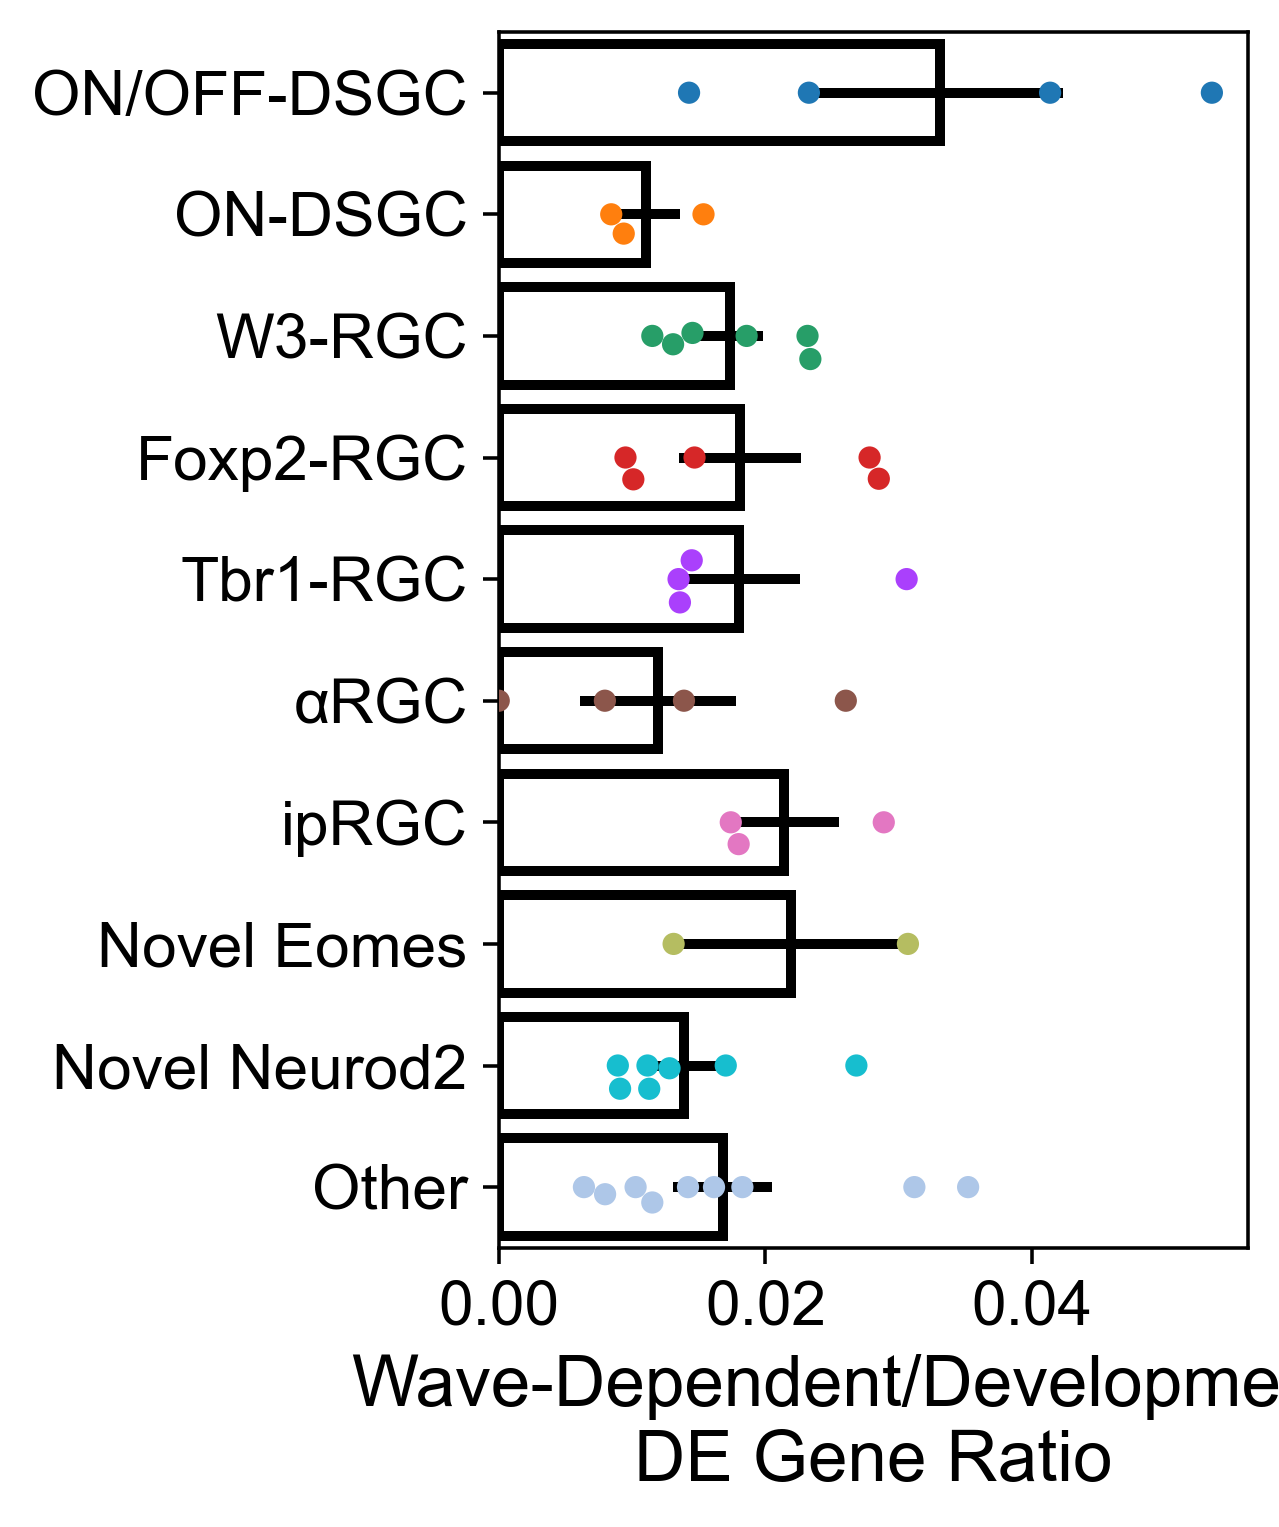

In [98]:
fig, axs = plt.subplots(figsize=(3,5))
sns.barplot(subclass_wave_dev_ratios, fill=False, color='black', errorbar='se', orient='h')
sns.swarmplot(subclass_wave_dev_ratios, size=5, orient='h')
plt.yticks(np.arange(len(subclass_wave_dev_ratios)), subclass_labels)
plt.xlabel('Wave-Dependent/Developmental\nDE Gene Ratio')
plt.grid(False)
plt.savefig('Wave_Dev_Ratios.svg', bbox_inches='tight')

In [99]:
stats.f_oneway(subclass_wave_dev_ratios['ooDSGC'], subclass_wave_dev_ratios['oDSGC'], subclass_wave_dev_ratios['W3RGC'], subclass_wave_dev_ratios['FRGC'], subclass_wave_dev_ratios['TRGC'], subclass_wave_dev_ratios['aRGC'], subclass_wave_dev_ratios['ipRGC'], subclass_wave_dev_ratios['Novel_Eomes'], subclass_wave_dev_ratios['Novel_Neurod2'], subclass_wave_dev_ratios['Other'])

F_onewayResult(statistic=1.7394890232687097, pvalue=0.11450343241677576)

In [102]:
type_order = [12, 16, 24, 10, 1, 13, 2, 6, 23, 30, 3, 4, 28, 38, 32, 5, 17, 21, 9, 42, 41, 43, 45, 31, 33, 40, 22, 7, 8, 19, 20, 25, 26, 29, 35, 39, 11, 14, 15, 18, 27, 34, 36, 37, 44]
reordered_types = [str(i) for i in type_order]
for i in ['12', '16', '24', '10']:
    reordered_types.remove(i)
for i in reversed(DS_types):
    reordered_types.insert(0, i)

In [105]:
biological_types = ["1_W3L1",
                    "2_W3D1",
                    "3_F-mini-ON",
                    "4_F-mini-OFF",
                    "5_J-RGC",
                    "6_W3B",
                    "7_Novel",
                    "8_Novel",
                    "9_Tbr1-Novel",
                    "10_ooDSGC",
                    "11_Novel",
                    "12_N-ooDSGC",
                    "13_W3L2",
                    "14_Novel",
                    "15_Novel",
                    "16_D/V-ooDSGC",
                    "17_Tbr1-S1",
                    "18_Novel",
                    "19_Novel",
                    "20_Novel",
                    "21_Tbr1-S2",
                    "22_MX",
                    "23_W3D2",
                    "24_ooDSGC",
                    "25_Novel",
                    "26_Novel",
                    "27_Novel",
                    "28_F-midi-OFF",
                    "29_Novel",
                    "30_W3D3",
                    "31_M2",
                    "32_F-Novel",
                    "33_M1",
                    "34_Novel",
                    "35_Novel",
                    "36_Novel",
                    "37_Novel",
                    "38_F-midi-ON",
                    "39_Novel",
                    "40_M1-duplicate",
                    "41_αON-T",
                    "42_αOFF-S",
                    "43_αON-S/M4",
                    "44_Novel",
                    "45_αOFF-T"
]

In [106]:
type_order = [12, 16, 24, 10, 1, 13, 2, 6, 23, 30, 3, 4, 28, 38, 32, 5, 17, 21, 9, 42, 41, 43, 45, 31, 33, 40, 22, 7, 8, 19, 20, 25, 26, 29, 35, 39, 11, 14, 15, 18, 27, 34, 36, 37, 44]
reordered_type_labels = ['C' + biological_types[i-1] for i in type_order]
for i in ['C12_N-ooDSGC', 'C16_D/V-ooDSGC', 'C24_ooDSGC', 'C10_ooDSGC']:
    reordered_type_labels.remove(i)
for i in ['C10_V-oDSGC', 'C10_D-oDSGC', 'C10_N-oDSGC', 'C24_T-ooDSGC', 'C12_N-ooDSGC', 'C16_V-ooDSGC', 'C16_D-ooDSGC']:
    reordered_type_labels.insert(0, i)

In [108]:
p7_matrix = []
p7b2_matrix = []
for i in reordered_types:
    p7_list = pruned_wave_p7_genes[i]
    p7b2_list = pruned_wave_p7b2_genes[i]
    p7_jaccards = []
    p7b2_jaccards = []
    for j in reordered_types:
        type_p7_list = pruned_wave_p7_genes[j]
        type_p7b2_list = pruned_wave_p7b2_genes[j]
        p7_inter = len([x for x in p7_list if x in type_p7_list])
        p7b2_inter = len([x for x in p7b2_list if x in type_p7b2_list])
        p7_union = len(p7_list) + len(type_p7_list) - p7_inter
        p7b2_union = len(p7b2_list) + len(type_p7b2_list) - p7b2_inter
        p7_jaccards.append((p7_inter+0.01)/(p7_union+0.01))
        p7b2_jaccards.append((p7b2_inter+0.01)/(p7b2_union+0.01))
    p7_matrix.append(p7_jaccards)
    p7b2_matrix.append(p7b2_jaccards)

In [110]:
subclass_dict = {'ooDSGC': ['D-ON/OFF', 'V-ON/OFF', 'N-ON/OFF', 'T-ON/OFF'],
                 'oDSGC': ['N-ON', 'D-ON', 'V-ON'],
                 'W3RGC': [1, 13, 2, 6, 23, 30],
                 'FRGC': [3, 4, 28, 38, 32],
                 'TRGC': [5, 17, 21, 9],
                 'aRGC': [42, 41, 43, 45],
                 'ipRGC': [31, 33, 40, 22],
                 'Novel_Eomes': [7, 8],
                 'Novel_Neurod2': [19, 20, 25, 26, 29, 35, 39],
                 'Other': [11, 14, 15, 18, 27, 34, 36, 37, 44]}

In [116]:
p7_p7b2_fold_changes_by_type_dict = {}
for i in tqdm(range(len(p7_p7b2_fold_changes_by_type))):
    p7_p7b2_fold_changes_by_type_dict[str(i+1)] = p7_p7b2_fold_changes_by_type[i]
for i in tqdm(range(len(p7_p7b2_fold_changes_by_type_DS))):
    p7_p7b2_fold_changes_by_type_dict[DS_types[i]] = p7_p7b2_fold_changes_by_type_DS[i]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


In [117]:
ultimate_blacklist = []
for i in tqdm(range(len(p7_p7b2_blacklist_by_type))):
    for j in p7_p7b2_blacklist_by_type[i] + p7_p56_blacklist_by_type[i] + p7_p5_blacklist_by_type[i]:
        if j not in ultimate_blacklist:
            ultimate_blacklist.append(j)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:16<00:00,  2.67it/s]


In [118]:
p7_p7b2_fold_changes_by_type_dict_filtered = {}
for i in tqdm(p7_p7b2_fold_changes_by_type_dict.keys()):
    fcs = p7_p7b2_fold_changes_by_type_dict[i]
    filt = [fcs[x] for x in range(len(fcs)) if x not in ultimate_blacklist]
    p7_p7b2_fold_changes_by_type_dict_filtered[i] = filt

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:34<00:00,  1.53it/s]


In [119]:
corr_mat = []
for i in tqdm(reordered_types):
    out_fcs = p7_p7b2_fold_changes_by_type_dict_filtered[i]
    row = []
    for j in reordered_types:
        in_fcs = p7_p7b2_fold_changes_by_type_dict_filtered[j]
        corr = stats.pearsonr(out_fcs, in_fcs)[0]
        row.append(corr)
    corr_mat.append(row)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.54it/s]


In [124]:
flat_inv_corr_mat = []
for i in range(len(corr_mat)):
    row = corr_mat[i][i+1:]
    for j in row:
        flat_inv_corr_mat.append(1-j)

In [125]:
corr_linkage_mat = sch.linkage(flat_inv_corr_mat)

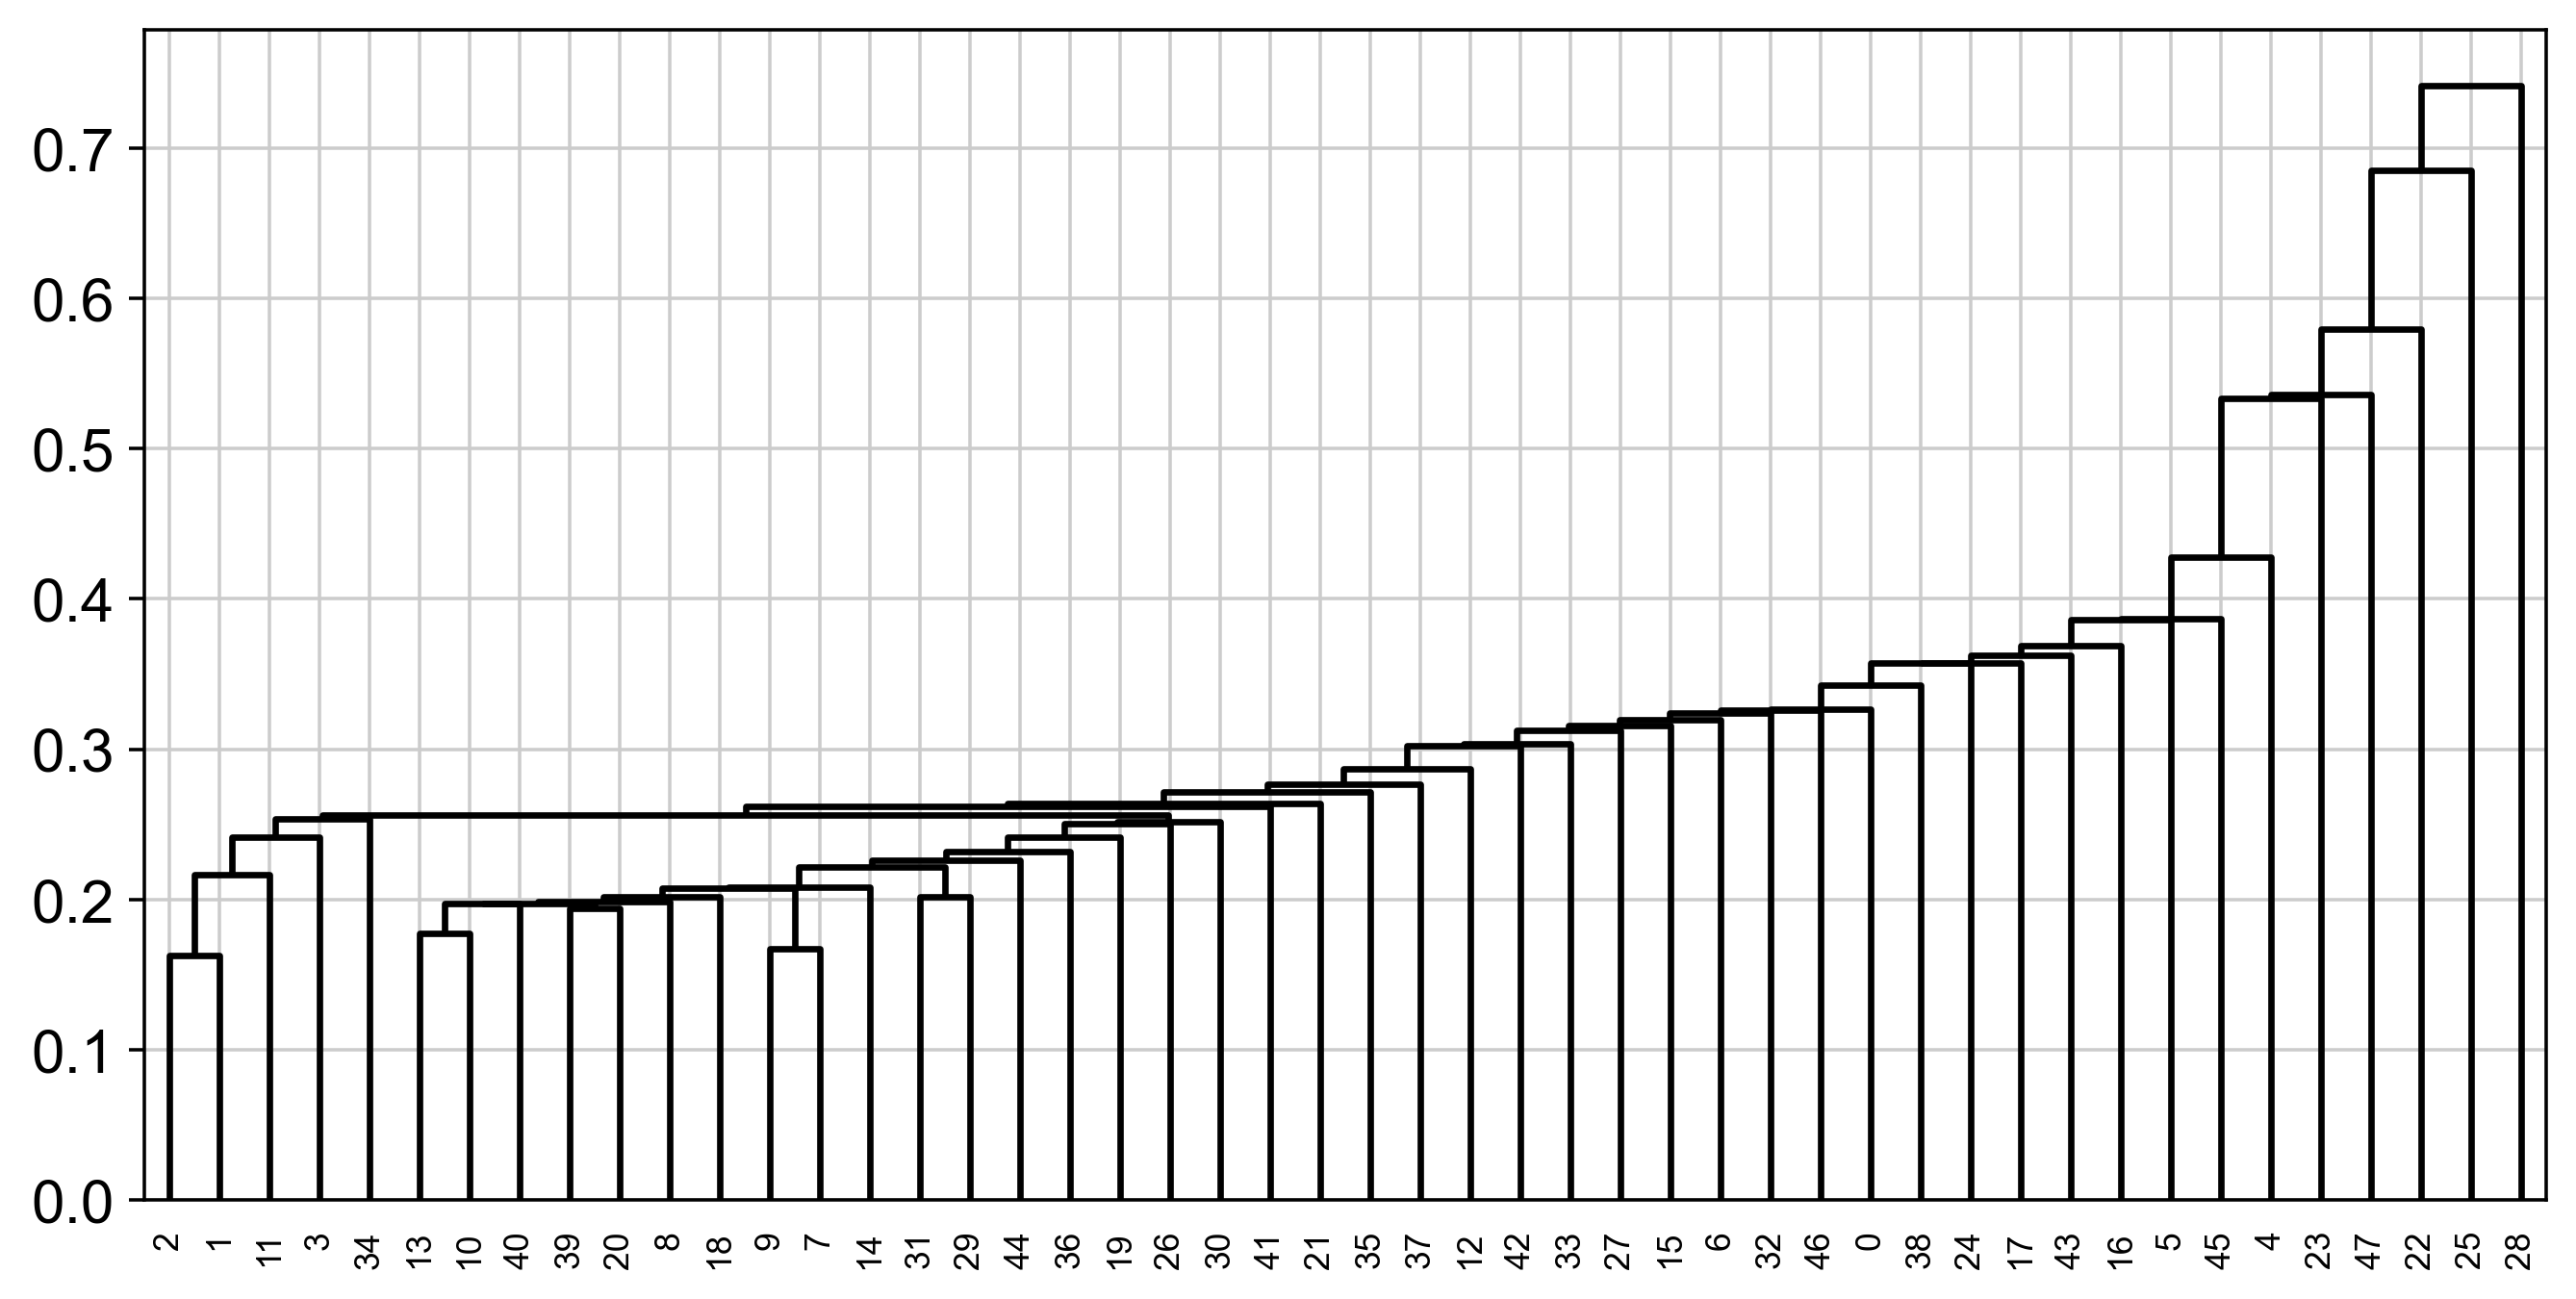

In [129]:
plt.subplots(figsize=(10,5))
sch.set_link_color_palette(['#000000'])
dendro_dict = sch.dendrogram(corr_linkage_mat, color_threshold=max(corr_linkage_mat[:, 2])+1, distance_sort='descending')
clustered_type_order = dendro_dict['leaves']

In [130]:
clustered_corr_mat = []
for i in clustered_type_order:
    row = corr_mat[i]
    new_row = [row[x] for x in clustered_type_order]
    clustered_corr_mat.append(new_row)

In [131]:
order = [reordered_type_labels[x] for x in clustered_type_order]

In [157]:
reordered_type_Cs = [x.split('_')[0] for x in reordered_type_labels]
reordered_type_Cs[0] = 'C16D'
reordered_type_Cs[1] = 'C16V'
reordered_type_Cs[4] = 'C10N'
reordered_type_Cs[5] = 'C10D'
reordered_type_Cs[6] = 'C10V'

In [158]:
clustered_type_names = [reordered_type_Cs[x] for x in clustered_type_order]

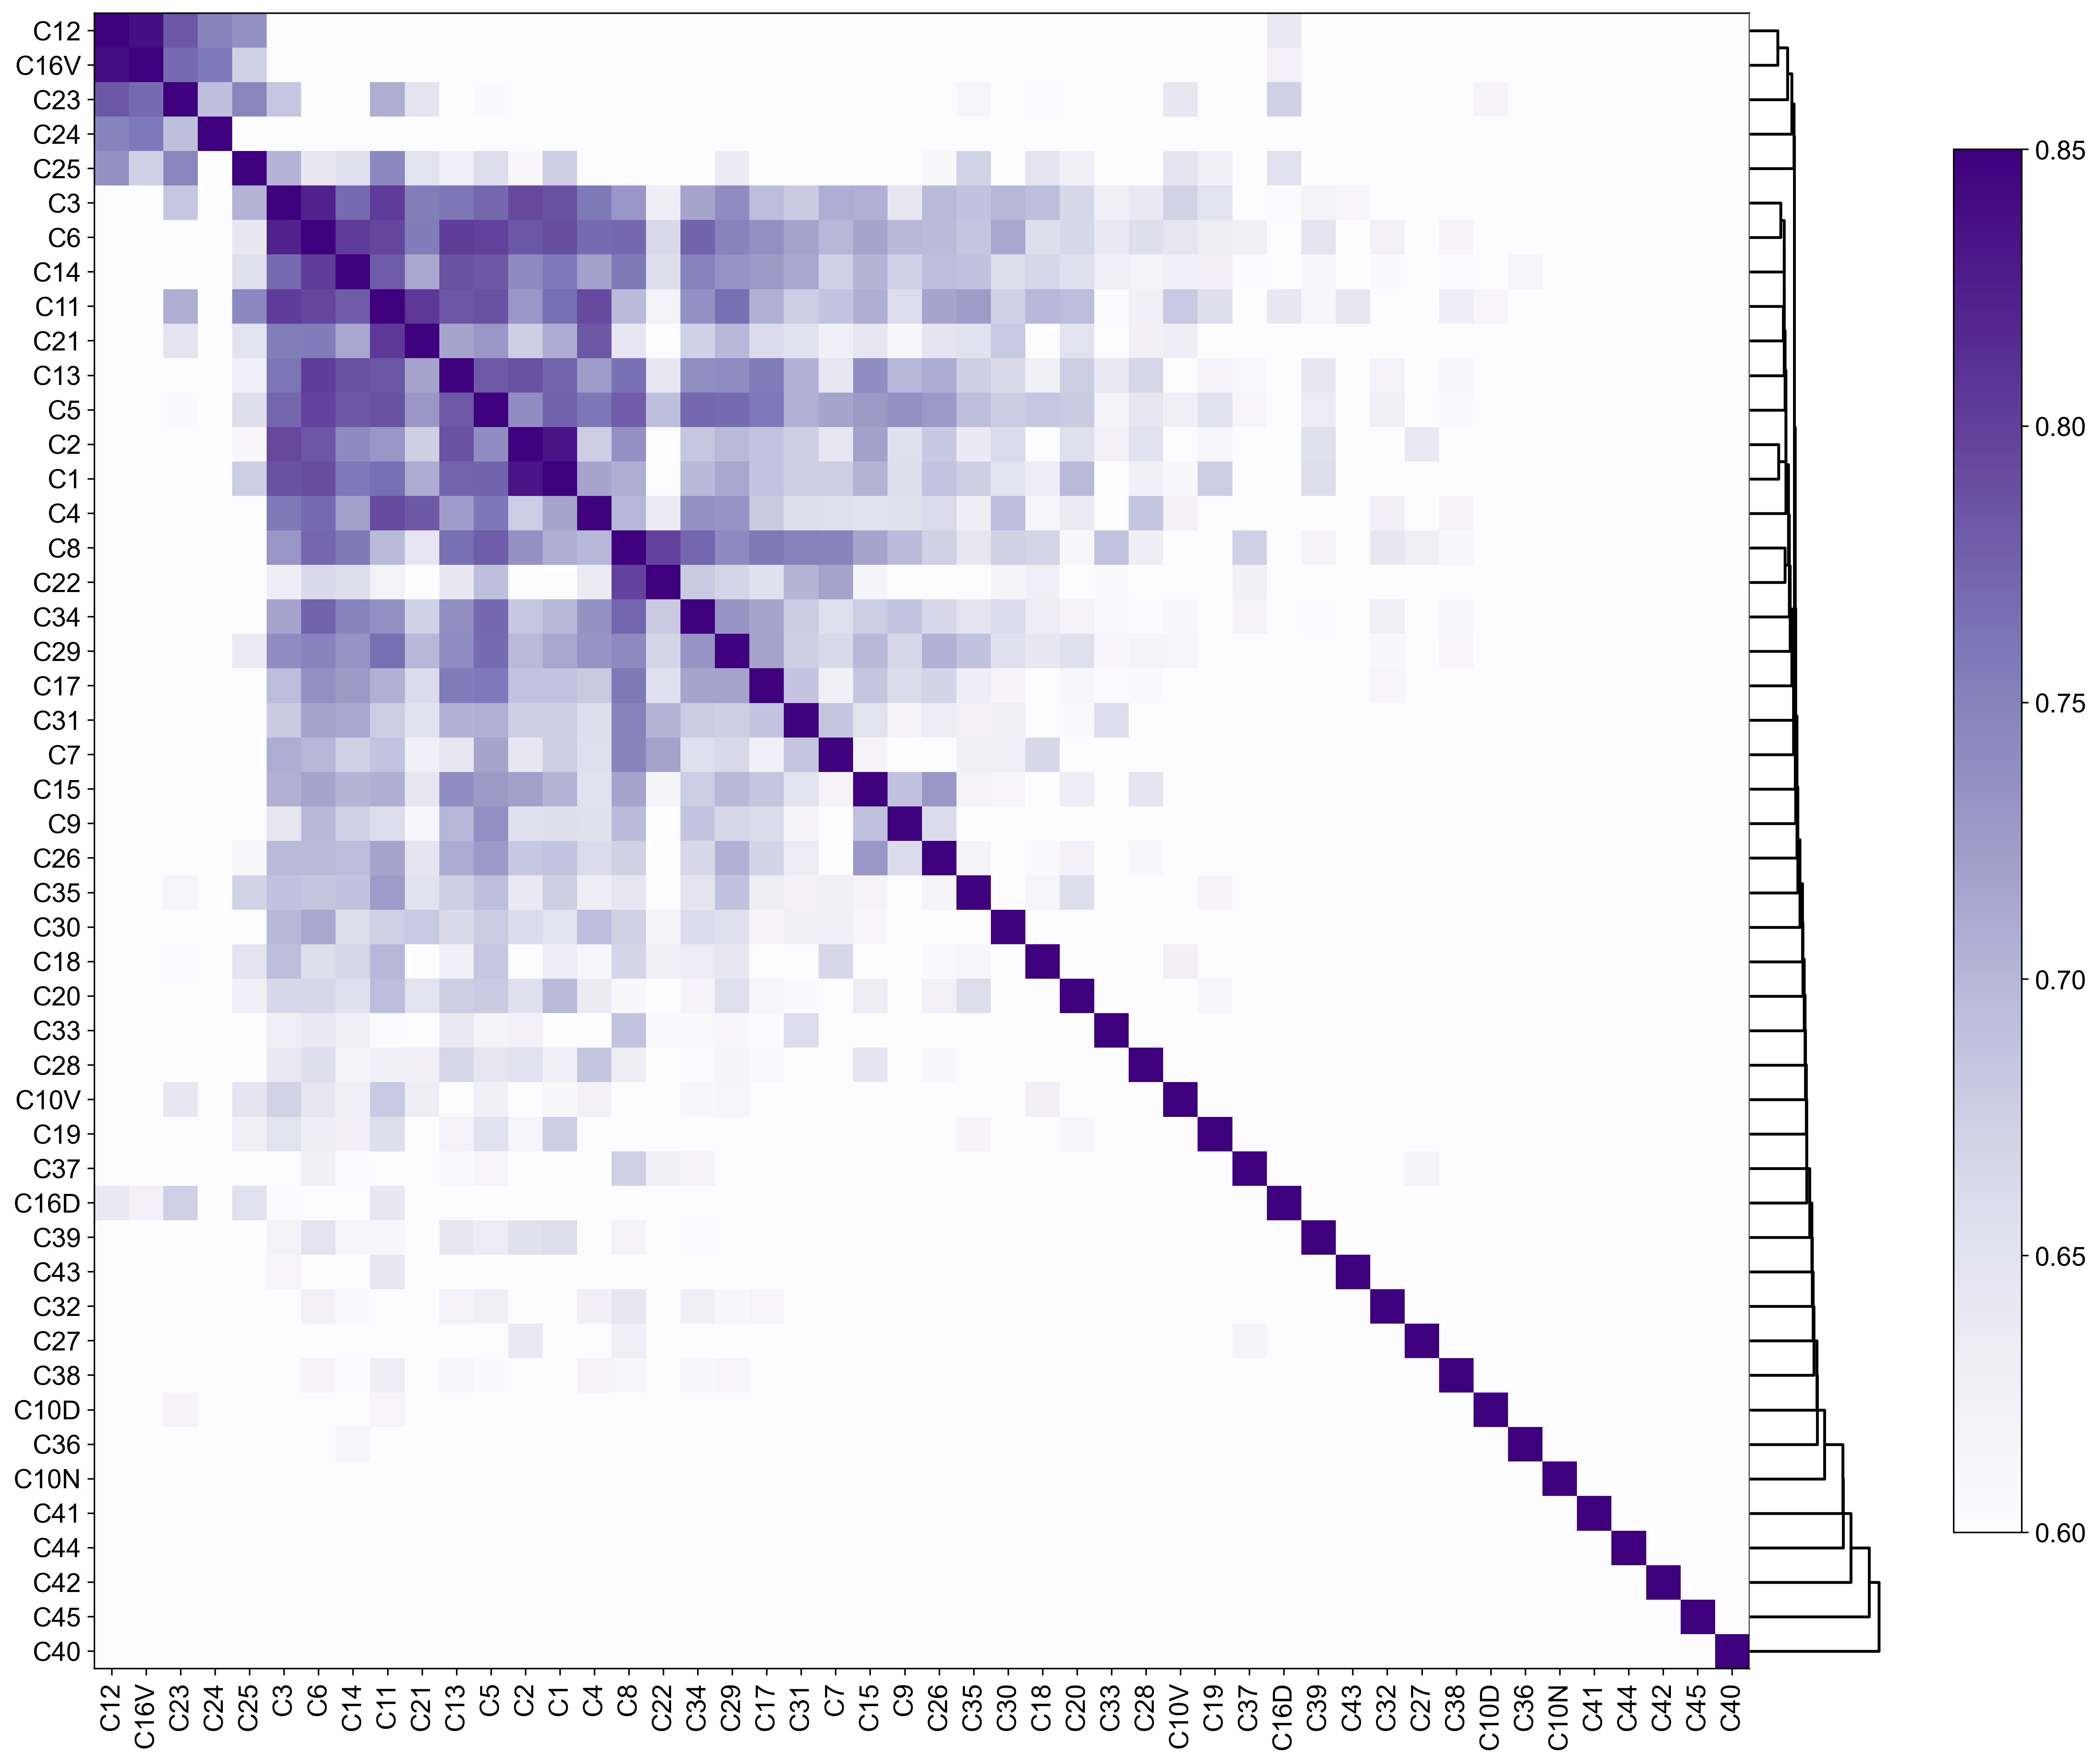

In [159]:
fig_width = len(clustered_corr_mat[0])/3
fig_height = len(clustered_corr_mat)/3

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
plt.imshow(clustered_corr_mat, cmap='Purples', vmin=0.6, vmax=0.85)

ax.set_xticks(np.arange(len(clustered_type_names)), clustered_type_names, rotation=90)
ax.set_yticks(np.arange(len(clustered_type_names)), clustered_type_names)

ax.grid(False)

pos = ax.get_position()

dend_y_ax = fig.add_axes([pos.x1, pos.y0, 1/fig_width, pos.y1-pos.y0])
dend_y_ax.grid(False)
dend_y_ax.spines["right"].set_visible(False)
dend_y_ax.spines["top"].set_visible(False)
dend_y_ax.spines["left"].set_visible(False)
dend_y_ax.spines["bottom"].set_visible(False)
sch.set_link_color_palette(['#000000'])
_ = sch.dendrogram(corr_linkage_mat, color_threshold=max(corr_linkage_mat[:, 2])+1, orientation='right', ax=dend_y_ax)
dend_y_ax.tick_params(axis="x", bottom=False, labelbottom=False, labeltop=False)
dend_y_ax.tick_params(axis="y", left=False, labelleft=False, labelright=False)

pos2 = dend_y_ax.get_position()
cbar_ax = fig.add_axes([pos2.x1+0.5/fig_width, pos2.y0+1/fig_height, 0.5/fig_width, pos.y1-pos.y0-2/fig_height])
plt.colorbar(cax=cbar_ax)
cbar_ax.grid(False)
plt.savefig('corr-heatmap-clustered.svg', bbox_inches='tight')

In [141]:
DS_markers = ['Cartpt', 'Col25a1', 'Pcdh11x', 'Fgd2', 'Dapl1', 'Ildr2', 'Zeb2', 'Gpc6', 'Neurod2', 'Mmp17', 'Trhr', 'Cidea', 'Kcnip3', 'Ndrg1', 'Irx4', 'Satb2', 'Irx6', 'Ptgfr', 'Tafa4', 'Scn7a', 'Piezo2', 'Ptprt', 'Gpr88', 'Syt6', 'Npy', 'Lbhd2', 'Ceacam10', 'Ptprk', 'Onecut3', 'Avil', 'Tbx5', 'Sfrp1', 'Shox2', 'Eya1', 'Shisa3', 'Cxcr4', 'Fibcd1', 'Gfi1']

In [142]:
mean_dfs = []
dot_size_dfs = []

gene_order_p5 = ['Cartpt', 'Col25a1', 'Pcdh11x', 'Fgd2', 'Dapl1', 'Ildr2', 'Zeb2', 'Gpc6', 'Neurod2', 'Mmp17', 'Trhr', 'Cidea', 'Kcnip3', 'Ndrg1', 'Irx4', 'Satb2', 'Irx6', 'Ptgfr', 'Fam19a4', 'Scn7a', 'Piezo2', 'Ptprt', 'Gpr88', 'Syt6', 'Npy', 'A230065H16Rik', 'Ceacam10', 'Ptprk', 'Onecut3', 'Avil', 'Tbx5', 'Sfrp1', 'Shox2', 'Eya1', 'Shisa3', 'Cxcr4', 'Fibcd1', 'Gfi1']
gene_order = gene_order_p5.copy()
genedf = sc.get.obs_df(
    p5_adata_DS,
    keys=['DS_type', *gene_order],
    use_raw=True
)
grouped = genedf.groupby('DS_type', observed=True)
mean_df = grouped.mean()

genedf_bool = genedf.copy()
genedf_bool[gene_order] = genedf[gene_order] > 0
dot_size_df = genedf.copy()
dot_size_df = genedf_bool.groupby('DS_type', observed=True).sum()/genedf_bool.groupby('DS_type', observed=True).count()

mean_dfs.append(mean_df)
dot_size_dfs.append(dot_size_df)

gene_order_p7 = DS_markers.copy()
gene_order = gene_order_p7.copy()
genedf = sc.get.obs_df(
    p7_adata_combined_DS,
    keys=['DS_type', *gene_order],
    use_raw=True
)
grouped = genedf.groupby('DS_type', observed=True)
mean_df = grouped.mean()

genedf_bool = genedf.copy()
genedf_bool[gene_order] = genedf[gene_order] > 0
dot_size_df = genedf.copy()
dot_size_df = genedf_bool.groupby('DS_type', observed=True).sum()/genedf_bool.groupby('DS_type', observed=True).count()

mean_dfs.append(mean_df)
dot_size_dfs.append(dot_size_df)

gene_order_p56 = ['Cartpt', 'Col25a1', 'Pcdh11x', 'Fgd2', 'Dapl1', 'Ildr2', 'Zeb2', 'Gpc6', 'Neurod2', 'Mmp17', 'Trhr', 'Cidea', 'Kcnip3', 'Ndrg1', 'Irx4', 'Satb2', 'Irx6', 'Ptgfr', 'Fam19a4', 'Scn7a', 'Piezo2', 'Ptprt', 'Gpr88', 'Syt6', 'Npy', 'A230065H16Rik', 'Ceacam10', 'Ptprk', 'Onecut3', 'Avil', 'Tbx5', 'Sfrp1', 'Shox2', 'Eya1', 'Shisa3', 'Cxcr4', 'Fibcd1', 'Gfi1']
gene_order = gene_order_p56.copy()
genedf = sc.get.obs_df(
    p56_adata_DS,
    keys=['DS_type', *gene_order],
    use_raw=True
)
grouped = genedf.groupby('DS_type', observed=True)
mean_df = grouped.mean()

genedf_bool = genedf.copy()
genedf_bool[gene_order] = genedf[gene_order] > 0
dot_size_df = genedf.copy()
dot_size_df = genedf_bool.groupby('DS_type', observed=True).sum()/genedf_bool.groupby('DS_type', observed=True).count()

mean_dfs.append(mean_df)
dot_size_dfs.append(dot_size_df)

In [145]:
xs_p5 = []
for i in range(len(DS_types)):
    xs_p5.append(np.ones(len(gene_order))+np.arange(len(gene_order)))

In [146]:
ys_p5 = []
for i in [3, 5, 7, 10, 13, 16, 19]:
    ys_p5.append(i*np.ones(len(gene_order)))

In [147]:
xs_p7 = []
for i in range(len(DS_types)):
    xs_p7.append(np.ones(len(gene_order))+np.arange(len(gene_order)));

In [148]:
ys_p7 = []
for i in [2, 4, 6, 9, 12, 15, 18]:
    ys_p7.append(i*np.ones(len(gene_order)))

In [149]:
xs_p56 = []
for i in range(5):
    xs_p56.append(np.ones(len(gene_order))+np.arange(len(gene_order)))

In [150]:
ys_p56 = []
for i in [1, 8, 11, 14, 17]:
    ys_p56.append(i*np.ones(len(gene_order)))

In [151]:
DS_types

['D-ON/OFF', 'V-ON/OFF', 'N-ON/OFF', 'T-ON/OFF', 'N-ON', 'D-ON', 'V-ON']

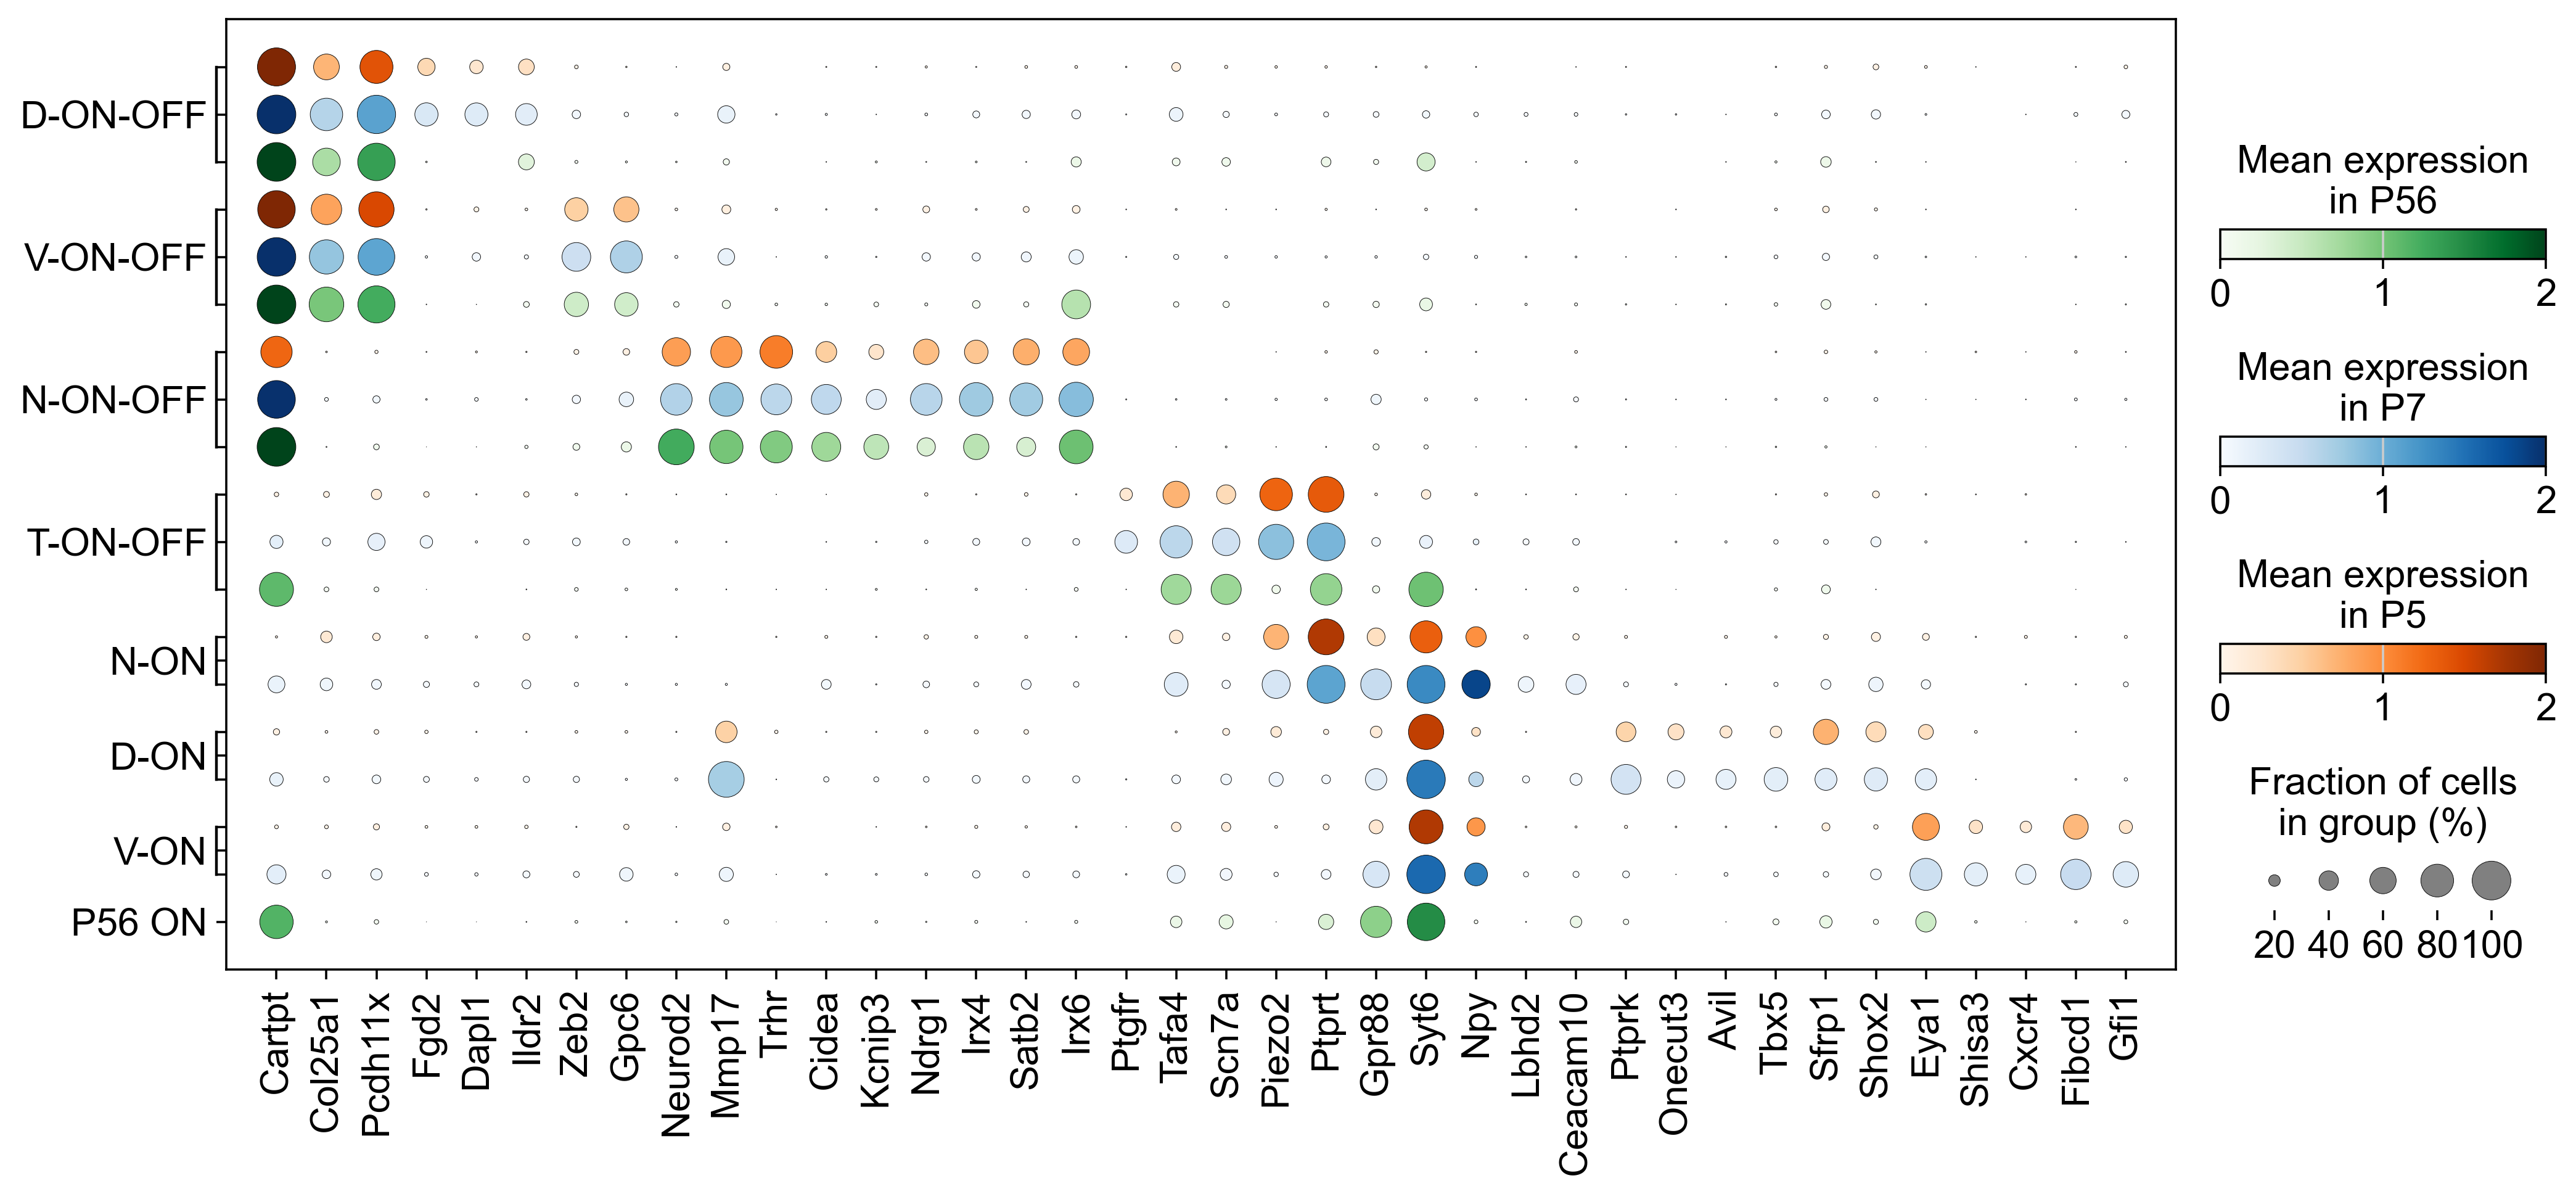

In [177]:
fig_width = len(gene_order)/3
fig_height = 19/3
fig, ax = plt.subplots(figsize=(fig_width,fig_height))

colors_p5 = np.flip(mean_dfs[0][gene_order_p5].to_numpy(), axis=0).flatten()
sizes_p5 = 200*np.flip(dot_size_dfs[0][gene_order_p5].to_numpy(), axis=0).flatten()**1.5
plt.scatter(xs_p5, ys_p5, c=colors_p5, cmap='Oranges', s=sizes_p5, vmin=0, vmax=2, edgecolor='black', linewidth=0.2)

colors_p7 = np.flip(mean_dfs[1][DS_markers].to_numpy(), axis=0).flatten()
sizes_p7 = 200*np.flip(dot_size_dfs[1][DS_markers].to_numpy(), axis=0).flatten()**1.5
plt.scatter(xs_p7, ys_p7, c=colors_p7, cmap='Blues', s=sizes_p7, vmin=0, vmax=2, edgecolor='black', linewidth=0.2)

colors_p56 = np.flip(mean_dfs[2][gene_order_p56].to_numpy(), axis=0).flatten()
sizes_p56 = 200*np.flip(dot_size_dfs[2][gene_order_p56].to_numpy(), axis=0).flatten()**1.5
plt.scatter(xs_p56, ys_p56, c=colors_p56, cmap='Greens', s=sizes_p56, vmin=0, vmax=2, edgecolor='black', linewidth=0.2)

plt.xticks(np.arange(len(gene_order))+1, DS_markers, rotation=90)
label_locs = [1, 2.5, 4.5, 6.5, 9, 12, 15, 18]
labels = ['P56 ON', 'V-ON', 'D-ON', 'N-ON', 'T-ON-OFF', 'N-ON-OFF', 'V-ON-OFF', 'D-ON-OFF']
for i in [2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 19]:
    label_locs.append(i)
    labels.append('')
plt.yticks(label_locs, labels)
plt.xlim([0,len(DS_markers)+1])
plt.ylim([0,19+1])
y0s = [2, 4, 6, 8, 11, 14, 17]
y1s = [3, 5, 7, 10, 13, 16, 19]
for i in range(len(y0s)):
    y0 = y0s[i]
    y1 = y1s[i]
    line = plt.plot([-0.2, -0.2], [y0, y1], linewidth = 1, color='black')
    line[0].set_clip_on(False)
plt.grid(False)

num_legend_dots = 5
size_pos = np.arange(num_legend_dots)
size_sizes = np.arange(0.2, 1.01, 0.2)
pos = ax.get_position()
size_ax = fig.add_axes([pos.x1+0.225/fig_width, pos.y0+0.3/fig_height, 1.65/fig_width, 0.3/fig_height])
size_ax.grid(False)
size_ax.spines["right"].set_visible(False)
size_ax.spines["top"].set_visible(False)
size_ax.spines["left"].set_visible(False)
size_ax.spines["bottom"].set_visible(False)
size_ax.tick_params(axis="y", left=False, labelleft=False, labelright=False)
size_ax.scatter(size_pos, len(size_pos)*[0], s=200*size_sizes**1.5, color='gray', edgecolor='black', linewidth=0.2)
size_ax.set_xlim([-1, num_legend_dots])
size_ax.set_xticks(size_pos, [round(100*i) for i in size_sizes])
size_ax.set_title("Fraction of cells\nin group (%)")

cmaps = ['Oranges', 'Blues', 'Greens']
adata_names = ['P5', 'P7', 'P56']
size_pos = size_ax.get_position()
current_y_pos = size_pos.y1
for i in range(3):
    color_ax = fig.add_axes([size_pos.x0, current_y_pos+0.9/fig_height, 1.65/fig_width, 0.15/fig_height])
    cbar = mpl.colorbar.ColorbarBase(color_ax, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=0, vmax=2), orientation='horizontal')
    color_ax.set_title("Mean expression\nin " + adata_names[i])
    current_y_pos = color_ax.get_position().y1
plt.savefig('DS_markers.svg', bbox_inches = 'tight')

In [182]:
DS_type_order_rename = ['D-ON-OFF', 'V-ON-OFF', 'N-ON-OFF', 'T-ON-OFF', 'N-ON', 'D-ON', 'V-ON']
DS_type_order_rename_p56 = ['D-ON-OFF', 'V-ON-OFF', 'N-ON-OFF', 'T-ON-OFF', 'ON']

In [179]:
p5_DS_types_renamed = []
for i in p5_adata_DS.obs['DS_type']:
    p5_DS_types_renamed.append(i.replace('/', '-'))
p5_adata_DS.obs['DS_type_rename'] = pd.Categorical(p5_DS_types_renamed)
p5_adata_DS.obs['DS_type_rename'] = p5_adata_DS.obs['DS_type_rename'].cat.reorder_categories(DS_type_order_rename)

In [180]:
p7_DS_types_renamed = []
for i in p7_adata_DS.obs['DS_type']:
    p7_DS_types_renamed.append(i.replace('/', '-'))
p7_adata_DS.obs['DS_type_rename'] = pd.Categorical(p7_DS_types_renamed)
p7_adata_DS.obs['DS_type_rename'] = p7_adata_DS.obs['DS_type_rename'].cat.reorder_categories(DS_type_order_rename)

In [183]:
p56_DS_types_renamed = []
for i in p56_adata_DS.obs['DS_type']:
    p56_DS_types_renamed.append(i.replace('/', '-'))
p56_adata_DS.obs['DS_type_rename'] = pd.Categorical(p56_DS_types_renamed)
p56_adata_DS.obs['DS_type_rename'] = p56_adata_DS.obs['DS_type_rename'].cat.reorder_categories(DS_type_order_rename_p56)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


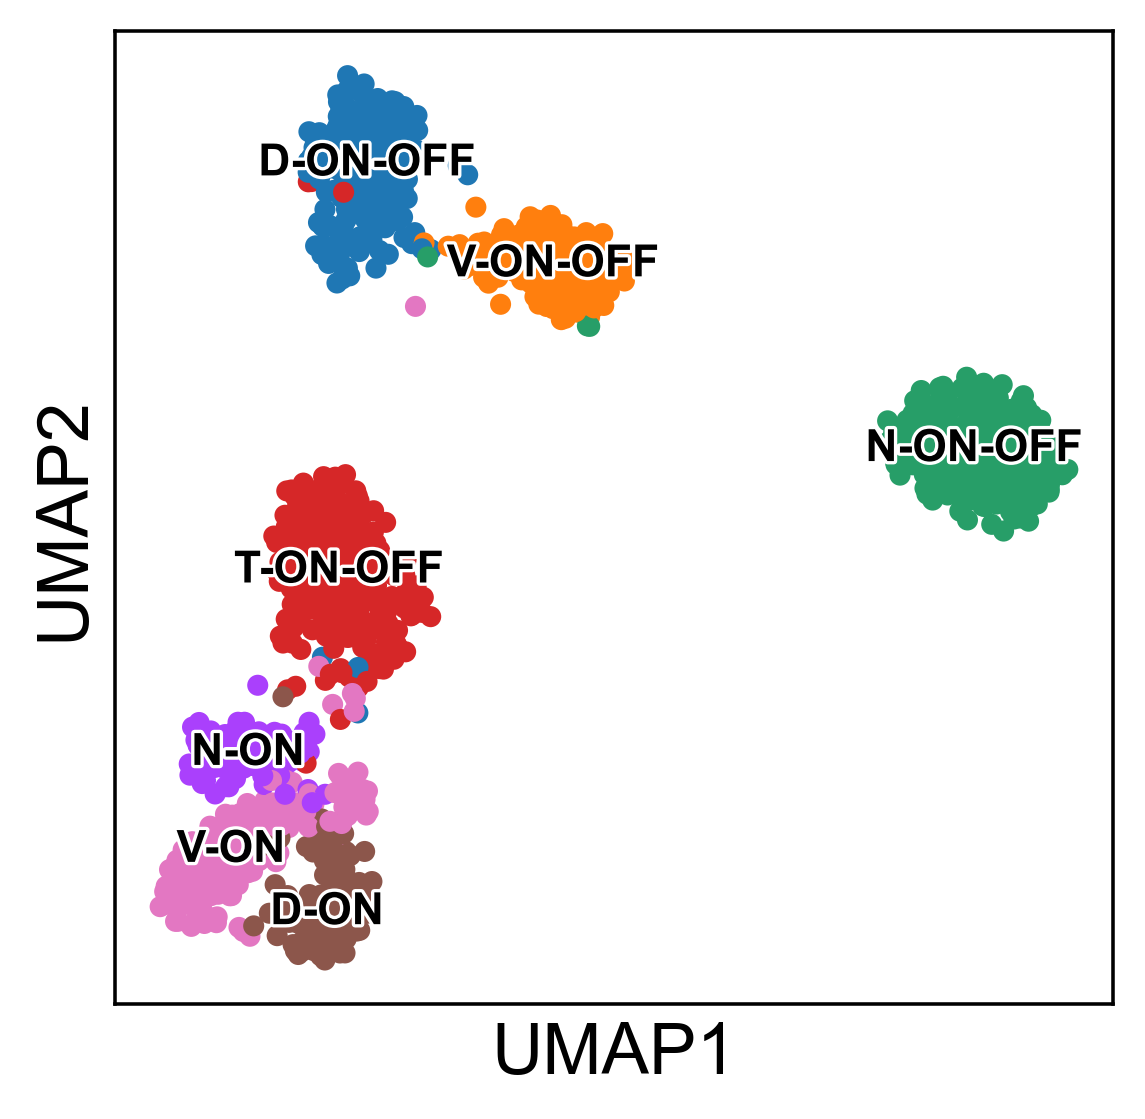

In [184]:
sc.pl.umap(p5_adata_DS, color='DS_type_rename', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, title='', save='_p5_DS_umap.svg')

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


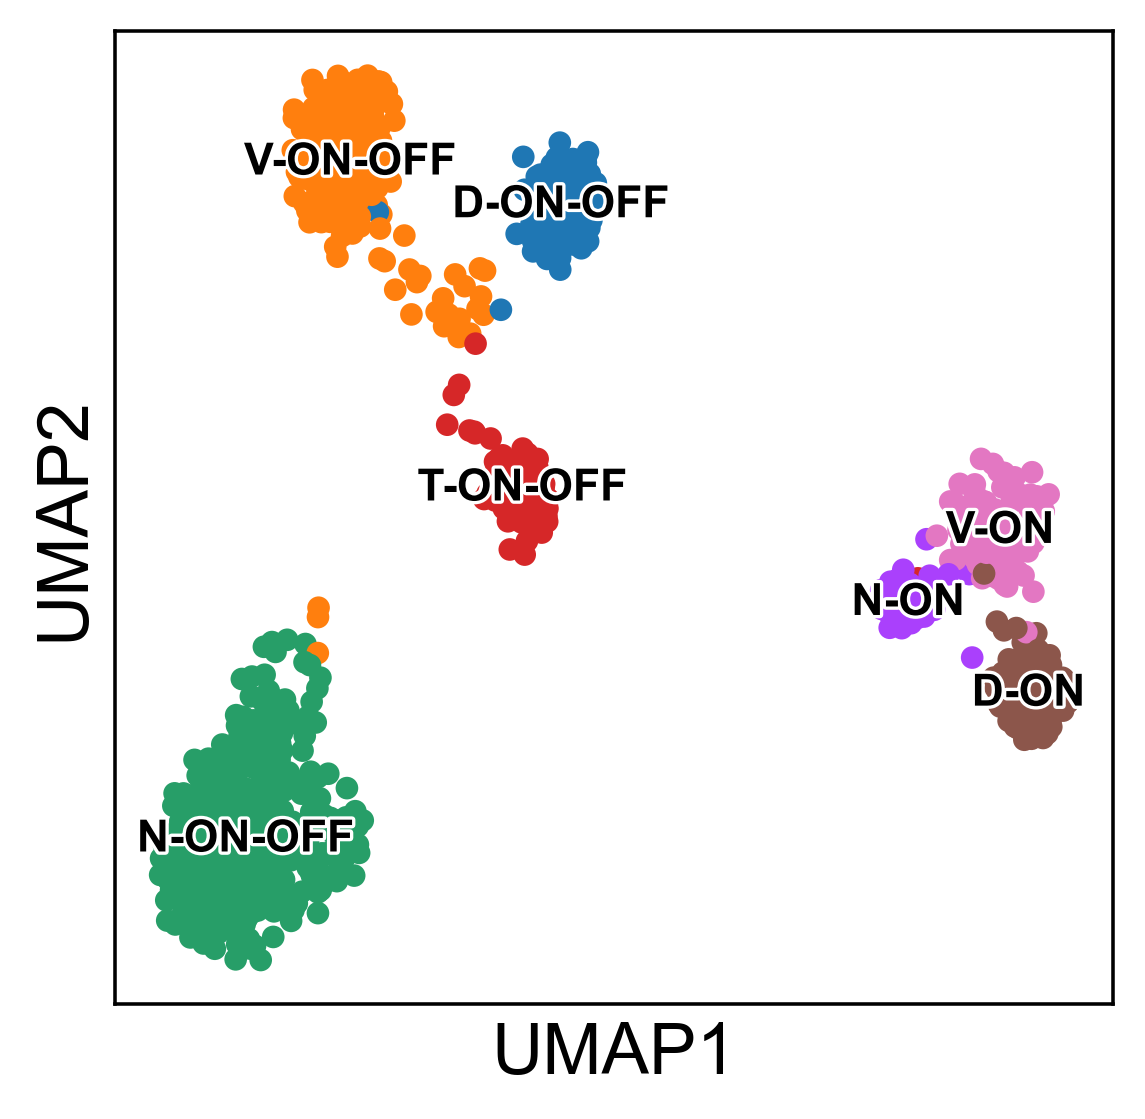

In [188]:
sc.pl.umap(p7_adata_DS, color='DS_type_rename', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, title='', save='_p7_DS_umap.svg')

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


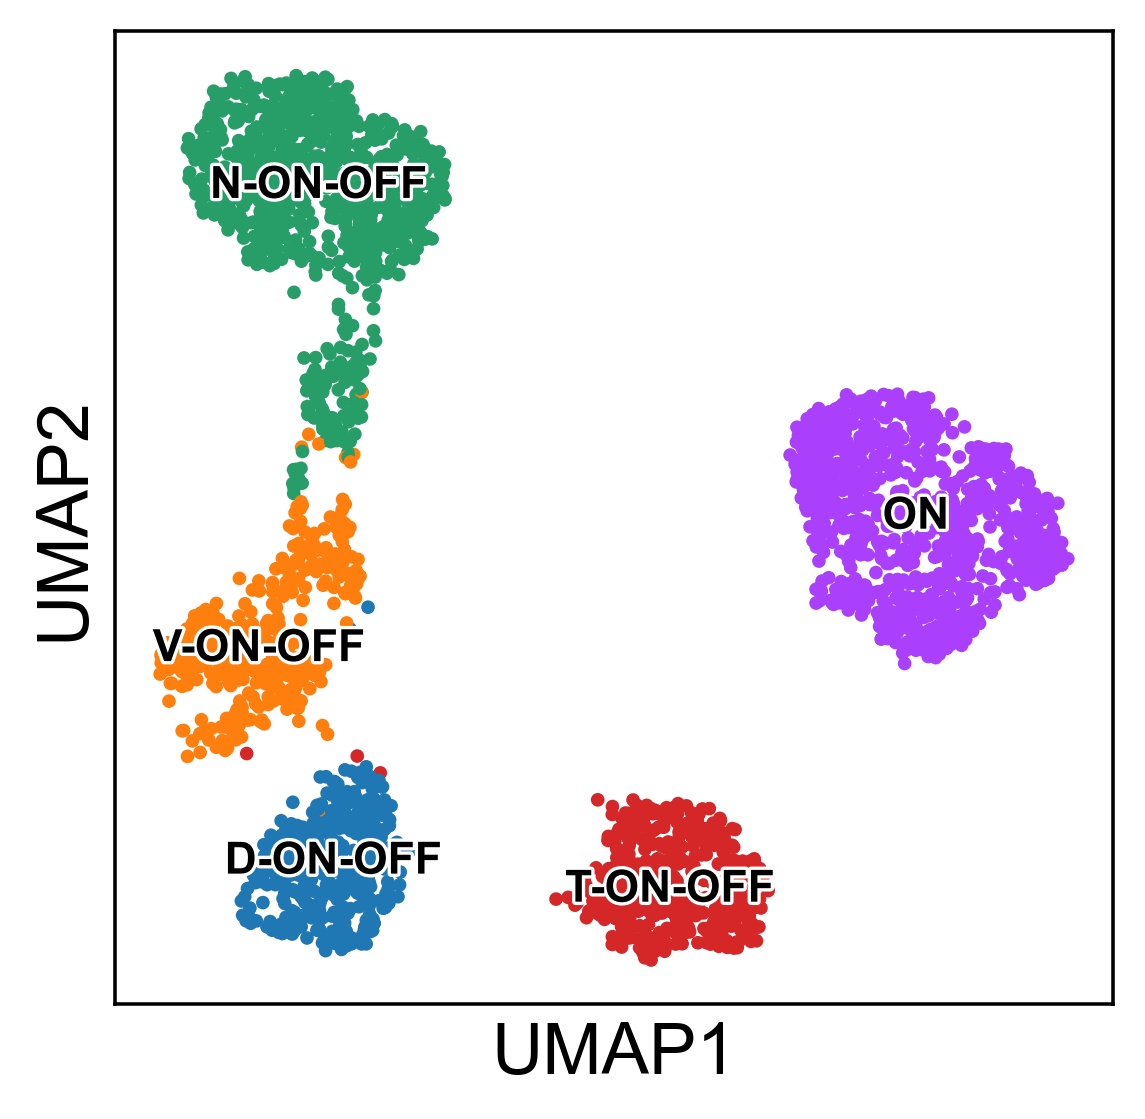

In [187]:
sc.pl.umap(p56_adata_DS, color='DS_type_rename', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, title='', save='_p56_DS_umap.svg')